In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import datetime

import matplotlib.pyplot as plt
from IPython import display

from scipy import stats
import math
import random

from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit, train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import  mean_squared_log_error

from xgboost import XGBRegressor

In [67]:
train_File = 'train.csv'
test_File = 'test.csv'

In [2]:
dd = display.display

# 1. Gather

In [3]:
def loadData():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    
    return df

df_before_clean = loadData()
dd(df_before_clean)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008
5,796,566,320,NaN,1,1Fam,TA,No,732.0,0.0,...,WD,0,Pave,5,796.0,AllPub,40,1993,1995,2009
6,1694,0,0,NaN,3,1Fam,TA,Av,1369.0,0.0,...,WD,0,Pave,7,1686.0,AllPub,255,2004,2005,2007
7,1107,983,0,NaN,3,1Fam,TA,Mn,859.0,32.0,...,WD,0,Pave,7,1107.0,AllPub,235,1973,1973,2009
8,1022,752,0,NaN,2,1Fam,TA,No,0.0,0.0,...,WD,0,Pave,8,952.0,AllPub,90,1931,1950,2008
9,1077,0,0,NaN,2,2fmCon,TA,No,851.0,0.0,...,WD,0,Pave,5,991.0,AllPub,0,1939,1950,2008


# 2. Assess Data : Inspecting Data for Quality and Tidiness Issues
#### 2.1 Quality Issues : Issues with content - missing, duplicate or incorrect data. a.k.a Dirty data 
* 2.1.a Completeness : *"Are there any rows, columns or cells missing values?"*
  * 35 columns have the missing values: 
  
  ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'PoolQC', 'SalePrice', 'SaleType', 'TotalBsmtSF', 'Utilities']
######   
* 2.1.b Validity : *"Does the data comply to the data schema like duplicate patient id or zip code being < 5 digits or float data type?"*
######   
   * Following are Categorical Variables but currently are being considered as integer/float:

        * MSSubClass
        * OverallQual
        * OverallCond
        * FireplaceQu
        * MoSold
######   
   * Following variables are supposed to be Integer type but Box-Cox or Scaling will anyway type cast them to float:

      * LotFrontage, LotArea, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, YrSold, SalePrice
   * GarageYrBlt will be NA when garage is not available for the house and hence this variable needs to be dropped as it does not comply to the schema.
   
######      
  
* 2.1.c Accuracy : *"Wrong data that is valid. like hieght = 300 inches; it still complies to the standard i.e. inches but data is in accurate."*
######   
    * MSZoning has 4 missing entries. Also, we do not have data samples to Agricultre (A),  Industrial (I), Residential Low Density Park (RP). Therefore, there exist a probability that missing entries will be replaced with wrong data which are valid for the variables.
######   
    * Similarly, Utilites has 2 missing entries. Also, we do not have data samples for NoSewr ((Electricity, Gas, and Water (Septic Tank)) and ELO (Electricity only)
######   
    * Exterior1st, has no missing values in training data set. But has no samples for 'Other' and 'PreCast' Material. Testing data has one missing sample for the variable.
######   
    * Exterior2nd has no missing values in the training data set. But has no samples for "PreCast" material. Testing data has one missing sample for the variable.
######   
    * MasVnrType has 8 missing values in training data set. It has total of 5 valid values.But there are no samples for "CBlock" (Cylinder block). One in testing set also has a record with missing value for this variable.
######   
    * ExterQual has no samples for "Po" but fortunately there are no missing values for it in both training or testing data.
######   
    * BsmtQual has 37 missing entries. It has no samples for "Po" ((Poor (<70 inches)). Testing data set has 46 missing entries.
######   
    * BsmtCond has 37 missing entries. It has no samples for "Ex" (Excellent). There are 46 missing entries in the testing dataset.
######   
    * KitchenQual has no training samples on "Po" but testing sample has a missing entry.
    * Functional has no training samples for "Po" but testing sample has a missing entry.
    * PoolQC has no samples for "Typ" but testing sample has missing values.
    * SaleType has no samples for "VWD" but testing sample has a missing value record.
######   
######   
* 2.1.d Consistency : *"Both valid and accurate but inconsistent. state = california and CA"*
######   
  * BsmtExposure has training samples as NA for both No Basement and also for missing values. There are also 2 testing samples with missing values as NA.
######   
  * BsmtFinType2 has training samples as NA for both No Basement and also for missing values.
######   
  * TotalBsmtSF has both 0 and NA representing as missing basement.
######   
  * BsmtExposure has NA for both missing and no basement houses.
  * BsmtFinType2 has NA for both missing and no basement for a house.
  


#### 2.2 Tidiness Issues: Issues with structure - untidy or messy data
* 2.2.a Each observation is a row
  * No Issues: Each observation is a unique house (no duplicate records)
######   
* 2.2.b Each variable is a column
  * No Issues: There are no colummns with multi data or concatenated data.
######  
* 2.2.c Each observational unit is a table
  * No Issues: There are no cross referring keys present in the table. Bsmt* and Garage* variables do form a logical group but there is no unique identities to the group.
######   

##### Hypothesis 1: Bsmt__ variables are NA when TotalBsmtSF is 0
##### Proof:
* BsmtFinType1 is NA when TotalBsmtSF is 0
* BsmtUnfSF is 0 whenever TotalBsmtSF is 0; Even in testing set it is NA only when TotalBsmtSF is NA
* BsmtFullBath is 0 whenever TotalBsmtSF is 0; Even in testin set it is NA only when TotalBsmtSF is NA or 0.
* BsmtHalfBath is 0 whenever TotalBsmtSF is 0; Even in testin set it is NA only when TotalBsmtSF is NA or 0.

##### Key Observations:
* Dataset has House Prices which were sold in between 2006 - 2010.
* Surprised to see no bathroom and no bedroom but with kitchen Houses !!! Where do they sleep and shit after the heavy meal ?
* NA value in GarageType can be easily mis interpreted as missing value. However, it is not true. NA in GarageType clearly indicates no garage because in both train and testing dataset GarageArea = 0 in all those cases. Similarly, GarageYrBlt, GarageFinish, GarageQual, GarageCond are also NA when GarageArea = 0. And GarageCars,GarageArea = 0 ==> GarageArea = 0.
* How do we verify NA in Fence as missing entry or No Fence ??
* How do we verify NA in MiscFeatures as None or missing value ?? Note that MiscVal is zero for NA, Othr & Shed.

### 2.1.a Completeness : *"Are there any rows, columns or cells missing values?"*

In [4]:
def missingValueAssessment(df):
    nan_columns = df.columns[df.isna().any()].tolist()
    print('NaN columns :', nan_columns, "\n# :", len(nan_columns))
    
    print("Duplicated rows count: ", df[df.duplicated()].shape)
    df = df.fillna('NA')
    print("Duplicated rows count: ", df[df.duplicated()].shape)
    
missingValueAssessment(df_before_clean)

NaN columns : ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'PoolQC', 'SalePrice', 'SaleType', 'TotalBsmtSF', 'Utilities'] 
# : 35
Duplicated rows count:  (0, 81)
Duplicated rows count:  (0, 81)


### 2.2.a Each observation is a row

In [5]:
def checkHouseIsRepeated(df):
    df_temp = df.groupby(['SalePrice','GrLivArea','YearBuilt','YearRemodAdd']).agg('count').reset_index()[['SalePrice','GrLivArea','YearBuilt','YearRemodAdd','Id']]
    dd("Samples with same 'SalePrice','GrLivArea','YearBuilt','YearRemodAdd' : ",df_temp[df_temp.Id > 1])
    
    
checkHouseIsRepeated(df_before_clean)

"Samples with same 'SalePrice','GrLivArea','YearBuilt','YearRemodAdd' : "

,SalePrice,GrLivArea,YearBuilt,YearRemodAdd,Id


* As there are no time series data: as in there is no variable indicating the time of the reading carried out, It is safe to assume the reading was done at one shot and there would not be any duplicate entries of a house.
* With the above assumption, group by 'SalePrice','GrLivArea','YearBuilt','YearRemodAdd' count indicates that there are no duplicate records.

In [6]:
df_before_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      291

# 3.0 Cleaning Data

##### Let us first do the cleaning activities where we have high confidence of imputing the values as listed in the above Assessment summary.

In [7]:
def cleanStage1(df):
    
    #convert data type
    #we are being little lineant to give float64 for YearBuilt, YrSold but those guys are going to be box-coxed 
    #so let them at least enjoy the bigger size for now
    float64_variables = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', \
                     'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', \
                     'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',\
                     'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
                     'PoolArea', 'MiscVal', 'YrSold', 'SalePrice']
    
    for c in float64_variables:
        df[c] = df[c].astype(np.float64)
    
    int_to_categorical_variables = ['MSSubClass', 'OverallQual', 'OverallCond', 'FireplaceQu', 'MoSold']
    for c in int_to_categorical_variables:
        df[c] = df[c].astype(str)
        
    
    #Blunt Initialization
    #df = df.fillna("NotAvailable")
    
    #TotalBsmtSF == NotAvailable
    df['TotalBsmtSF'] = df.TotalBsmtSF.fillna("NotAvailable")
    df['TotalBsmtSF'] = df.TotalBsmtSF.apply(lambda x: 0 if "NotAvailable" == x else x)
    
    #BsmtQual	BsmtCond	BsmtExposure	BsmtFinType1	BsmtFinType2
    df['BsmtQual'] = df.apply(lambda x: "NA" if x['TotalBsmtSF'] == 0 else x['BsmtQual'], axis=1)
    df['BsmtCond'] = df.apply(lambda x: "NA" if x['TotalBsmtSF'] == 0 else x['BsmtCond'], axis=1)
    df['BsmtExposure'] = df.apply(lambda x: "NA" if x['TotalBsmtSF'] == 0 else x['BsmtExposure'], axis=1)
    df['BsmtFinType1'] = df.apply(lambda x: "NA" if x['TotalBsmtSF'] == 0 else x['BsmtFinType1'], axis=1)
    df['BsmtFinType2'] = df.apply(lambda x: "NA" if x['TotalBsmtSF'] == 0 else x['BsmtFinType2'], axis=1)
    #BsmtFullBath	BsmtHalfBath
    df['BsmtFullBath'] = df.apply(lambda x: 0 if x['TotalBsmtSF'] == 0 else x['BsmtFullBath'], axis=1)
    df['BsmtHalfBath'] = df.apply(lambda x: 0 if x['TotalBsmtSF'] == 0 else x['BsmtHalfBath'], axis=1)
    
    #BsmtFinSF1	BsmtFinSF2	BsmtUnfSF
    df['BsmtFinSF1'] = df.apply(lambda x: "NA" if x['TotalBsmtSF'] == 0 else x['BsmtFinSF1'], axis=1)
    df['BsmtFinSF2'] = df.apply(lambda x: "NA" if x['TotalBsmtSF'] == 0 else x['BsmtFinSF2'], axis=1)
    df['BsmtUnfSF'] = df.apply(lambda x: "NA" if x['TotalBsmtSF'] == 0 else x['BsmtUnfSF'], axis=1)
    
    #GarageYrBlt	GarageFinish GarageQual	GarageCond GarageCars	GarageArea
    #df['GarageType'] = df.GarageType.apply(lambda x: "NA" if "NotAvailable" == x else x)
    df['GarageType'] = df.GarageType.fillna("NA")
    #df['GarageYrBlt'] = df.apply(lambda x: "NA" if x['GarageType'] == "NA" else x['GarageYrBlt'], axis=1)
    df['GarageFinish'] = df.apply(lambda x: "NA" if x['GarageType'] == "NA" else x['GarageFinish'], axis=1)
    
    df['GarageQual'] = df.apply(lambda x: "NA" if x['GarageType'] == "NA" else x['GarageQual'], axis=1)
    df['GarageCond'] = df.apply(lambda x: "NA" if x['GarageType'] == "NA" else x['GarageCond'], axis=1)
    
    df['GarageCars'] = df.apply(lambda x: 0 if x['GarageType'] == "NA" else x['GarageCars'], axis=1)
    df['GarageArea'] = df.apply(lambda x: 0 if x['GarageType'] == "NA" else x['GarageArea'], axis=1)
    
    #drop obsolete columns
    df = df.drop(['Id','GarageYrBlt'], axis=1)
    df['SalePrice'] = df.SalePrice.fillna(0)
    return df

df_stage_1 = cleanStage1(df_before_clean.copy())
df_stage_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 79 columns):
1stFlrSF         2919 non-null float64
2ndFlrSF         2919 non-null float64
3SsnPorch        2919 non-null float64
Alley            198 non-null object
BedroomAbvGr     2919 non-null float64
BldgType         2919 non-null object
BsmtCond         2916 non-null object
BsmtExposure     2916 non-null object
BsmtFinSF1       2919 non-null object
BsmtFinSF2       2919 non-null object
BsmtFinType1     2919 non-null object
BsmtFinType2     2918 non-null object
BsmtFullBath     2919 non-null float64
BsmtHalfBath     2919 non-null float64
BsmtQual         2917 non-null object
BsmtUnfSF        2919 non-null object
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null float64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st  

##### We had map when TotalBsmtSF =0 , there are couple of entries when it is TotalBsmtSF != 0. We may have to other Bsmt- attributes to impute the values for it but we will do such analysis after the straight forward missing value imputation.

In [8]:
df_stage_1[df_stage_1.BsmtQual.isna()]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
2217,825.0,536.0,0.0,NaN,2.0,1Fam,Fa,No,0,0,...,WD,0.0,Pave,6.0,173.0,AllPub,0.0,1895.0,1950.0,2008.0
2218,671.0,378.0,0.0,NaN,2.0,1Fam,TA,No,0,0,...,WD,0.0,Pave,5.0,356.0,AllPub,0.0,1910.0,2000.0,2008.0


##### We have now 27 columns to look after for the first round of cleaning.

In [9]:
len(df_stage_1.columns[df_stage_1.isna().any()].tolist()), df_stage_1.columns[df_stage_1.isna().any()].tolist()

(24,
 ['Alley',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType2',
  'BsmtQual',
  'Electrical',
  'Exterior1st',
  'Exterior2nd',
  'Fence',
  'Functional',
  'GarageArea',
  'GarageCars',
  'GarageCond',
  'GarageFinish',
  'GarageQual',
  'KitchenQual',
  'LotFrontage',
  'MSZoning',
  'MasVnrArea',
  'MasVnrType',
  'MiscFeature',
  'PoolQC',
  'SaleType',
  'Utilities'])

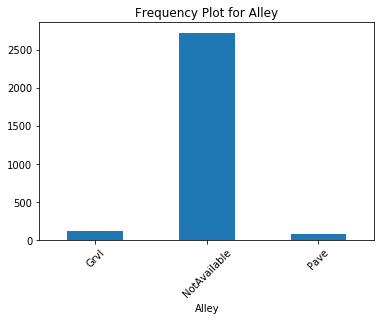

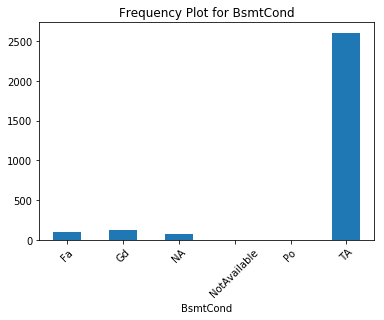

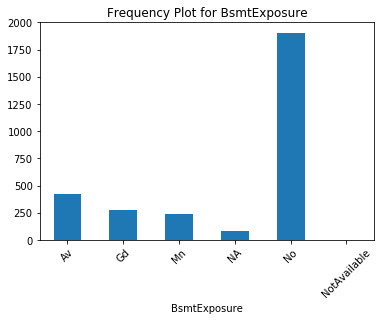

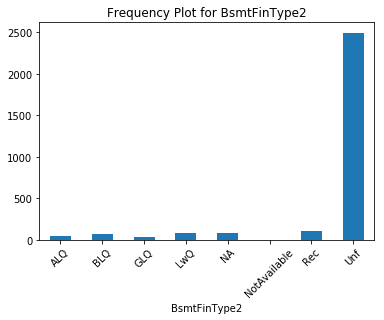

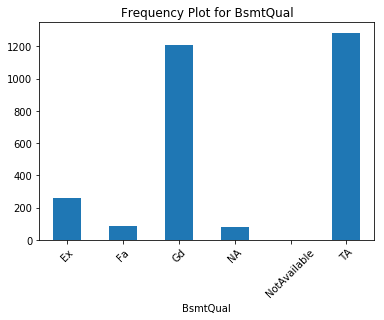

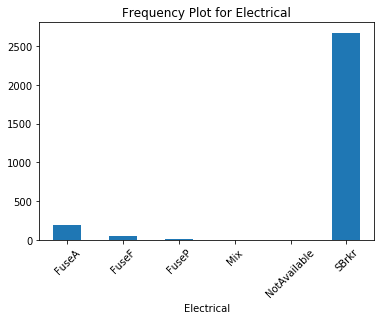

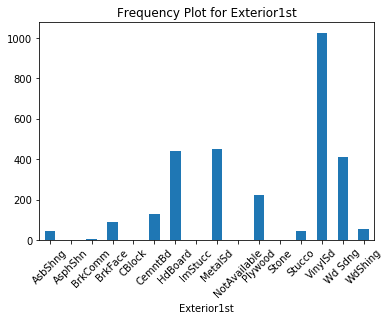

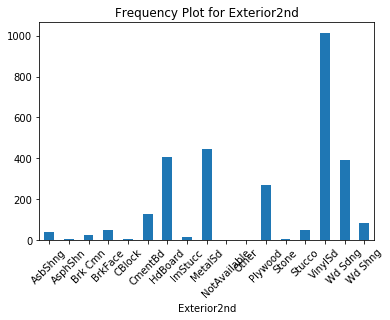

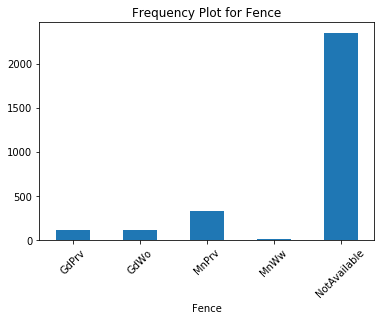

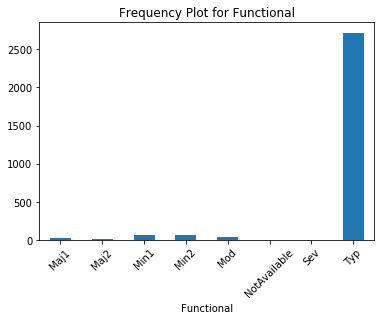

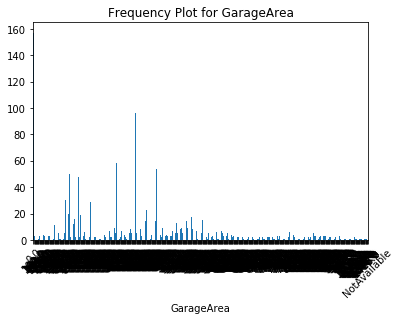

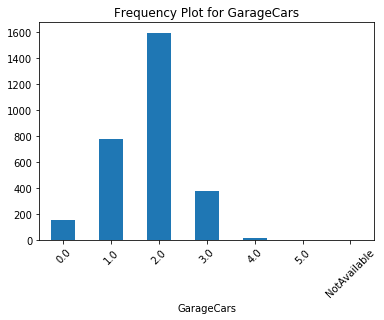

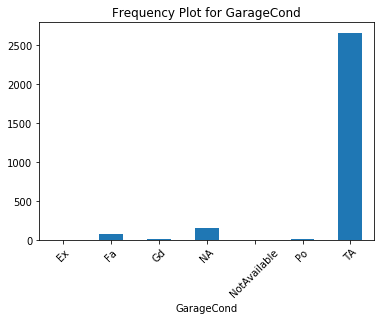

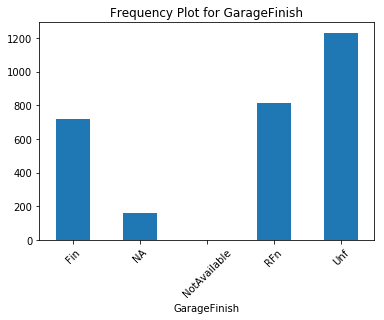

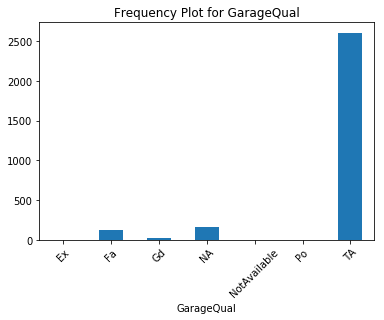

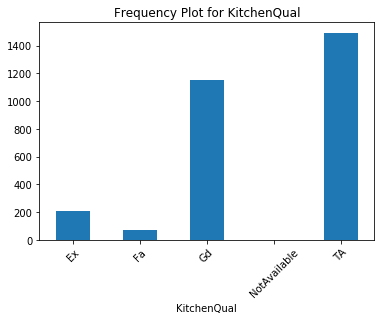

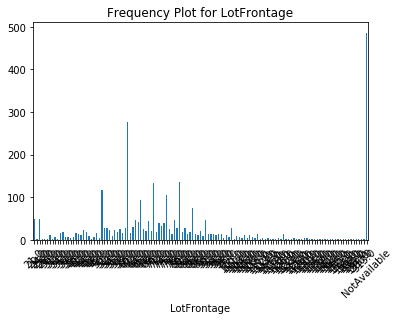

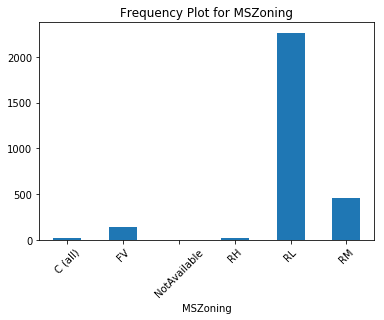

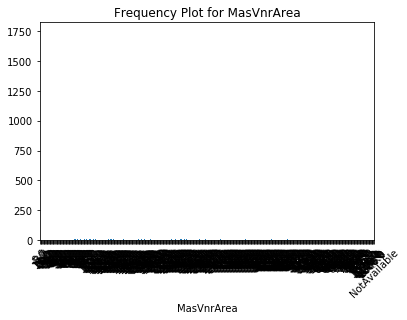

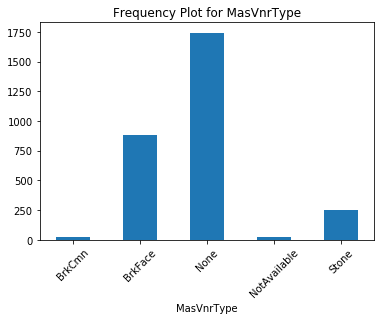

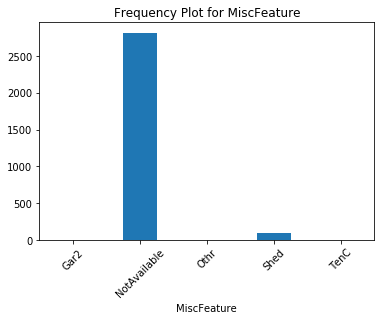

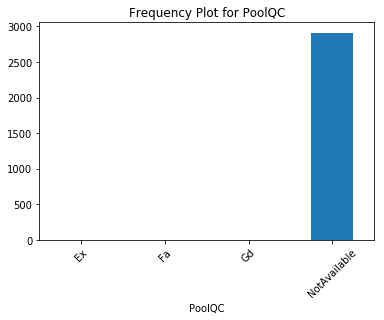

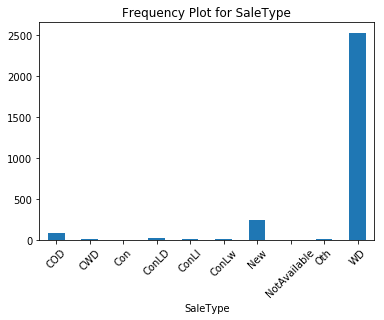

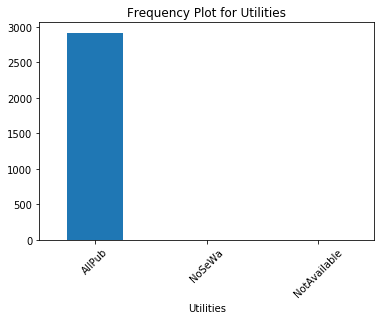

In [10]:
def plotNAs(df):
    nan_columns = df.columns[df.isna().any()].tolist()
    #nan_columns.remove('SalePrice')
    for c in df.fillna('NotAvailable')[nan_columns]:
        df[[c,'SalePrice']].fillna('NotAvailable').\
        groupby(by=c).agg('count').\
        plot.bar(legend=None, title="Frequency Plot for "+c)
        plt.xticks(rotation=45)
        plt.show()
plotNAs(df_stage_1.copy())

### 1. Alley

Initial Shape :  (2919, 79)


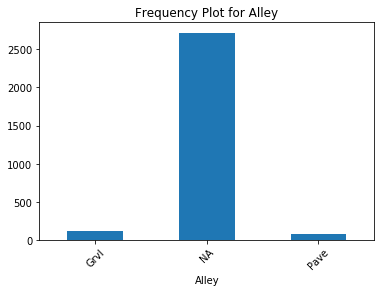

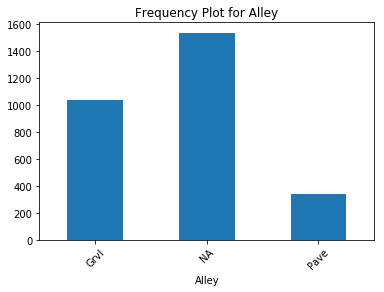

Alley Snapshot Before : NA - 2721 Grvl -  120 Pave -  78
Alley Snapshot After  : NA - 1538 Grvl -  1041 Pave -  340


In [11]:
def outerLandScape(df_temp):
    df = df_temp.copy()
    print("Initial Shape : ", df.shape)
    
    beyond_house = ['Neighborhood','Street', 'PavedDrive', 'Alley']
    df_temp = df.groupby(beyond_house).agg('count').reset_index()[['Neighborhood','Street', 'PavedDrive', 'Alley',"SalePrice"]]
    dd()
    
    def getAlley(Street, Neighborhood, PavedDrive):
        try:
            alley = df_temp[
                (df_temp['Street'] == Street ) &
                (df_temp['Neighborhood'] == Neighborhood ) &
                (df_temp['PavedDrive'] == PavedDrive) 
            ]['Alley'].tolist()[0]
        except:
            alley = 'NA'
        
        return alley
        
    
    df['Alley'] = df.Alley.fillna("NA")
    df[['Alley','SalePrice']].fillna(0).\
        groupby(by='Alley').agg('count').\
        plot.bar(legend=None, title="Frequency Plot for "+'Alley')
    plt.xticks(rotation=45)
    plt.show()
    
    na_alley_count = df[df.Alley == "NA"].shape[0]
    gr_alley_count = df[df.Alley == "Grvl"].shape[0]
    pa_alley_count = df[df.Alley == "Pave"].shape[0]
    
        
    df['Alley'] = df.apply( lambda x: getAlley (x['Street']
                                                ,x['Neighborhood']
                                                ,x['PavedDrive']
                                               ) if x['Alley'] == "NA" else x['Alley']
        ,axis=1)
    
    
    df[['Alley','SalePrice']].fillna(0).\
        groupby(by='Alley').agg('count').\
        plot.bar(legend=None, title="Frequency Plot for "+'Alley')
    plt.xticks(rotation=45)
    plt.show()
    
    
    print("Alley Snapshot Before : NA -", na_alley_count,"Grvl - ", gr_alley_count, "Pave - ", pa_alley_count)
    print("Alley Snapshot After  : NA -", df[df.Alley == "NA"].shape[0],
          "Grvl - ", df[df.Alley == "Grvl"].shape[0], "Pave - ", df[df.Alley == "Pave"].shape[0]
         )
    
    return df

df_alley = outerLandScape(df_stage_1)

In [12]:
def outerLandScape2():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    print("Initial Shape : ", df.shape)
    
    '''beyond_house = [ 'MSZoning','Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
                      'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'PavedDrive','SaleCondition','Fence', 'Alley']
    df_temp = df[beyond_house].copy()
    for c in beyond_house:
        df_temp = df_temp[df_temp[c].notna()]#.reset_index()
        print(c, df_temp.shape)'''
    #display.display(df_temp)
    
    #beyond_house = ['Neighborhood','Street', 'PavedDrive', 'Alley']
    #df = df.fillna('NNN')
    beyond_house = ['Neighborhood','Street','Alley']
    #beyond_house = ['Street', 'Alley']
    
    #display.display(df.groupby(beyond_house).agg('count').reset_index()[['Neighborhood','Street', 'PavedDrive', 'Alley','Id']])
    display.display(df.groupby(beyond_house).agg('count').reset_index()[['Neighborhood','Street', 'Alley','Id']])
    
    
outerLandScape2()

Initial Shape :  (2919, 81)


,Neighborhood,Street,Alley,Id
0,BrkSide,Pave,Pave,8
1,Crawfor,Pave,Grvl,4
2,Edwards,Pave,Grvl,9
3,IDOTRR,Pave,Grvl,15
4,IDOTRR,Pave,Pave,2
5,NAmes,Pave,Grvl,2
6,NAmes,Pave,Pave,1
7,OldTown,Pave,Grvl,89
8,OldTown,Pave,Pave,10
9,SWISU,Pave,Grvl,1


##### We can have the above table mapping missing Alley variable values. I am here assuming that Street and Alley would intersect. Therefore, there is a pattern with respect to location regarding the type of material used.

* However, the variable itself might not have such significance to target variable and hence can we can drop the imputation to it. The model which uses this variable would give lower significance level during training.

### 2. Electrical

In [13]:
def electricalWrangling(df_temp):
    df = df_temp.copy()
    df1 = df_temp.copy()
    print(df[df.Electrical.isna()].shape)
    df['Electrical'] = df.Electrical.fillna('NA')
    display.display(df[['Neighborhood','Electrical', 'SalePrice']].groupby(['Neighborhood','Electrical']).agg('count'))
    
    df1['Electrical'] = df1.Electrical.fillna('SBrkr')
    display.display(df1[['Neighborhood','Electrical', 'SalePrice']].groupby(['Neighborhood','Electrical']).agg('count'))
    return df1
    
df_electrical = electricalWrangling(df_stage_1)

(1, 79)


SalePrice
Neighborhood Electrical           
Blmngtn      SBrkr              28
Blueste      SBrkr              10
BrDale       SBrkr              30
BrkSide      FuseA              23
             FuseF               5
             SBrkr              80
ClearCr      FuseA               2
             FuseF               1
             SBrkr              41
CollgCr      SBrkr             267
Crawfor      FuseA               6
             FuseF               4
             SBrkr              93
Edwards      FuseA              20
             FuseF              15
             FuseP               2
             SBrkr             157
Gilbert      FuseA               1
             SBrkr             164
IDOTRR       FuseA              22
             FuseF               8
             FuseP               2
             Mix                 1
             SBrkr              60
MeadowV      SBrkr              37
Mitchel      FuseA               2
             SBrkr             112
NAmes        FuseA              50
             FuseF               6
             FuseP               1
             SBrkr             386
NPkVill      SBrkr              23
NWAmes       SBrkr             131
NoRidge      SBrkr              71
NridgHt      SBrkr             166
OldTown      FuseA              49
             FuseF               6
             FuseP               3
             SBrkr             181
SWISU        FuseA               5
             FuseF               4
             SBrkr              39
Sawyer       FuseA               5
             FuseF               1
             SBrkr             145
SawyerW      FuseA               2
             SBrkr             123
Somerst      SBrkr             182
StoneBr      SBrkr              51
Timber       FuseA               1
             NA                  1
             SBrkr              70
Veenker      SBrkr              24

SalePrice
Neighborhood Electrical           
Blmngtn      SBrkr              28
Blueste      SBrkr              10
BrDale       SBrkr              30
BrkSide      FuseA              23
             FuseF               5
             SBrkr              80
ClearCr      FuseA               2
             FuseF               1
             SBrkr              41
CollgCr      SBrkr             267
Crawfor      FuseA               6
             FuseF               4
             SBrkr              93
Edwards      FuseA              20
             FuseF              15
             FuseP               2
             SBrkr             157
Gilbert      FuseA               1
             SBrkr             164
IDOTRR       FuseA              22
             FuseF               8
             FuseP               2
             Mix                 1
             SBrkr              60
MeadowV      SBrkr              37
Mitchel      FuseA               2
             SBrkr             112
NAmes        FuseA              50
             FuseF               6
             FuseP               1
             SBrkr             386
NPkVill      SBrkr              23
NWAmes       SBrkr             131
NoRidge      SBrkr              71
NridgHt      SBrkr             166
OldTown      FuseA              49
             FuseF               6
             FuseP               3
             SBrkr             181
SWISU        FuseA               5
             FuseF               4
             SBrkr              39
Sawyer       FuseA               5
             FuseF               1
             SBrkr             145
SawyerW      FuseA               2
             SBrkr             123
Somerst      SBrkr             182
StoneBr      SBrkr              51
Timber       FuseA               1
             SBrkr              71
Veenker      SBrkr              24

##### At Timber, most of them have SBrkr as electrical system. So, it is a safe bet to have the missing entry replaced with 'SBrkr'

### 3. Exterior1st & Exterior2nd

In [14]:
def exteriorWrangle(df_temp):
    df = df_temp.copy()
    dd(df.shape)
    dd(df[df.Exterior1st == df.Exterior2nd].shape)
    dd(df[df.Exterior1st.isna()][['Exterior1st','Exterior2nd', 'Neighborhood','ExterQual', 'ExterCond', 'MSSubClass']])
    dd(df[df.Exterior2nd.isna()][['Exterior1st','Exterior2nd', 'Neighborhood','ExterQual', 'ExterCond','MSSubClass']])
    dt = df.\
       groupby(['Exterior1st','Exterior2nd', 'Neighborhood','ExterQual', 'ExterCond', 'MSSubClass']).\
       agg('count').reset_index().\
       sort_values(by=['MSSubClass','SalePrice'],ascending=False)[['Exterior1st','Exterior2nd', 'Neighborhood','ExterQual', 'ExterCond','MSSubClass','SalePrice']]
    #dd(dt)
    dd(dt[(dt.MSSubClass == '30') & (dt.Neighborhood == 'Edwards')].head())
    
    def bestExt1(Neighborhood,ExterQual, ExterCond, MSSubClass):
        return dt[(dt.Neighborhood == Neighborhood)&
                  (dt.ExterQual == ExterQual)&
                  (dt.ExterCond ==  ExterCond)&
                  (dt.MSSubClass == MSSubClass)]['Exterior1st'].tolist()[0]
    
    def bestExt2(Neighborhood,ExterQual, ExterCond, MSSubClass):
        return dt[(dt.Neighborhood == Neighborhood)&
                  (dt.ExterQual == ExterQual)&
                  (dt.ExterCond ==  ExterCond)&
                  (dt.MSSubClass == MSSubClass)]['Exterior2nd'].tolist()[0]
        
    df['Exterior1st'] = df.Exterior1st.fillna('NA')
    df['Exterior2nd'] = df.Exterior2nd.fillna('NA')
    
    df['Exterior1st'] = df.apply(lambda x: bestExt1(
                                    x['Neighborhood'], x['ExterQual'], x['ExterCond'], x['MSSubClass']
                                    ) if x['Exterior1st'] =="NA" else x['Exterior1st'], axis=1)
    df['Exterior2nd'] = df.apply(lambda x: bestExt1(
                                    x['Neighborhood'], x['ExterQual'], x['ExterCond'], x['MSSubClass']
                                    ) if x['Exterior2nd'] =="NA" else x['Exterior2nd'], axis=1)
    dd(df[df.index == 2151][['Exterior1st','Exterior2nd', 'Neighborhood','ExterQual', 'ExterCond', 'MSSubClass']])
    return df
    

    
df_ext = exteriorWrangle(df_electrical)

(2919, 79)

(2481, 79)

,Exterior1st,Exterior2nd,Neighborhood,ExterQual,ExterCond,MSSubClass
2151,NaN,NaN,Edwards,TA,TA,30


,Exterior1st,Exterior2nd,Neighborhood,ExterQual,ExterCond,MSSubClass
2151,NaN,NaN,Edwards,TA,TA,30


,Exterior1st,Exterior2nd,Neighborhood,ExterQual,ExterCond,MSSubClass,SalePrice
831,Wd Sdng,Wd Sdng,Edwards,TA,TA,30,5
327,MetalSd,MetalSd,Edwards,TA,TA,30,3
551,Stucco,Stucco,Edwards,TA,TA,30,2
170,HdBoard,HdBoard,Edwards,TA,TA,30,1
442,MetalSd,Wd Sdng,Edwards,TA,TA,30,1


,Exterior1st,Exterior2nd,Neighborhood,ExterQual,ExterCond,MSSubClass
2151,Wd Sdng,Wd Sdng,Edwards,TA,TA,30


##### it is observed that many of the houses have Exterior1st and Exterior2nd same values per neighborhood. Therefore, we will create a matrix of neighborhood and Exterior1st. We will first populate Exterior1st from neighborhood value and then we will populate Exterior2nd from Exterior1st.

### 4. Fence

In [15]:
def fenceWrangling(df_temp):
    df = df_temp.copy()

    print("Count of missing Fence : ",df[df.Fence.isna()].shape)
    
    df['Fence'] = df.Fence.fillna('NA')
    
    #dd(df.groupby(['MSSubClass', 'Neighborhood','Fence', ]).agg('count').reset_index()[['MSSubClass', 'Neighborhood','Fence', 'SalePrice']])
    dd(df.groupby(['Neighborhood','Fence', ]).agg('count').reset_index()[['Neighborhood','Fence', 'SalePrice']])
    return df
    
df_fence = fenceWrangling(df_ext)

Count of missing Fence :  (2348, 79)


,Neighborhood,Fence,SalePrice
0,Blmngtn,NA,28
1,Blueste,GdPrv,5
2,Blueste,MnPrv,2
3,Blueste,NA,3
4,BrDale,GdPrv,1
5,BrDale,NA,29
6,BrkSide,GdPrv,9
7,BrkSide,GdWo,4
8,BrkSide,MnPrv,19
9,BrkSide,MnWw,1


##### It is too tedious to decide if missing value indicates "NA" - No Fence or the entry was missing. What does actually Fence depend on ?
* For now i m going to rely on NA for the missing entry. Safest assumption.

##### It is too risky to map from othe rvariables. Though it seems like it depends on LotArea or LotFrontage. It is not very clear if it depends solely on one of the variable or sort of combination of others. Let us keep it NA for missing values, so that it would mean no fence available.

### 5.0 Functional

In [16]:
def functionalWrangle(df_temp):
    df = df_temp.copy()
   
    display.display(df[df.Functional.isna()].shape)
    
    co_qu_columns = [c for c in list(df) if ("Co" in c) or ("Qu" in c)]
    co_qu_columns.append('SalePrice')
    co_qu_columns.append('Functional')
    print(co_qu_columns)
    
    display.display(df[df.Functional.isna()])
    display.display(df[df.Functional.isna()][co_qu_columns])
    
    dd(df[(df.OverallCond == 5) & (df.OverallQual == 1)][co_qu_columns])
    dd(df[(df.OverallCond == 1) & (df.OverallQual == 4)][co_qu_columns])
    
    df['Functional'] = df.Functional.fillna('Typ')
    
    return df
    
df_funct = functionalWrangle(df_fence)


(2, 79)

['BsmtCond', 'BsmtQual', 'Condition1', 'Condition2', 'ExterCond', 'ExterQual', 'FireplaceQu', 'GarageCond', 'GarageQual', 'KitchenQual', 'LandContour', 'LotConfig', 'LowQualFinSF', 'OverallCond', 'OverallQual', 'SaleCondition', 'SalePrice', 'Functional']


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
2216,733.0,0.0,0.0,NaN,2.0,1Fam,NA,NA,NA,NA,...,WD,0.0,Pave,4.0,0.0,AllPub,0.0,1952.0,1952.0,2008.0
2473,866.0,504.0,0.0,Grvl,3.0,1Fam,Fa,No,0,0,...,COD,84.0,Pave,6.0,771.0,AllPub,14.0,1910.0,1950.0,2007.0


,BsmtCond,BsmtQual,Condition1,Condition2,ExterCond,ExterQual,FireplaceQu,GarageCond,GarageQual,KitchenQual,LandContour,LotConfig,LowQualFinSF,OverallCond,OverallQual,SaleCondition,SalePrice,Functional
2216,NA,NA,Norm,Norm,Po,Fa,nan,Po,Fa,Fa,Low,Inside,0.0,5,1,Abnorml,0.0,NaN
2473,Fa,TA,Artery,Norm,Fa,Fa,nan,Fa,TA,TA,Lvl,Corner,114.0,1,4,Abnorml,0.0,NaN


,BsmtCond,BsmtQual,Condition1,Condition2,ExterCond,ExterQual,FireplaceQu,GarageCond,GarageQual,KitchenQual,LandContour,LotConfig,LowQualFinSF,OverallCond,OverallQual,SaleCondition,SalePrice,Functional


,BsmtCond,BsmtQual,Condition1,Condition2,ExterCond,ExterQual,FireplaceQu,GarageCond,GarageQual,KitchenQual,LandContour,LotConfig,LowQualFinSF,OverallCond,OverallQual,SaleCondition,SalePrice,Functional


##### the rule itself says, assume typical unless deductions are warranted. However, there is no entry of salvage in our data set. Though it is not mandatory to have all categorical values has to be there in the dataset but it always raises the question why not that variable ? Can *Cond and *Qu variable give us hint of not 'Sal' ?

* I am actually tempted to put 'Sal' but due to lack of samples for Sal, I will be putting it as 'Typ'

### 6. LotFrontage

In [17]:
def LotFrontagecheck(df_temp):
    df = df_temp.copy()
    #df = pd.read_csv('train.csv')
    print(df[df.LotFrontage.isna()].shape)
    df_LotFrontage = df[['Neighborhood','LotFrontage']].groupby('Neighborhood').agg(lambda x:x.value_counts().index[0]).reset_index()
    df_dict = dict([tuple(x) for x in df_LotFrontage.values])
    print(df_dict)
    
    df['LotFrontage'] =df.LotFrontage.fillna(-1)
    df['LotFrontage'] =df.apply(lambda x: df_dict[x['Neighborhood']] if x['LotFrontage'] == -1 else x['LotFrontage'],axis=1)
    print(df[df.LotFrontage.isna()].shape)
    
    '''df.plot.scatter('LotFrontage', 'SalePrice')
    df.plot.scatter('LotArea', 'SalePrice')
    df.plot.scatter('LotArea', 'LotFrontage')
    
    display.display(df[df.LotFrontage > 175])'''
    return df
    
df_lot = LotFrontagecheck(df_funct) 

(486, 79)
{'Blmngtn': 43.0, 'Blueste': 24.0, 'BrDale': 21.0, 'BrkSide': 50.0, 'ClearCr': 80.0, 'CollgCr': 65.0, 'Crawfor': 80.0, 'Edwards': 60.0, 'Gilbert': 59.0, 'IDOTRR': 60.0, 'MeadowV': 21.0, 'Mitchel': 62.0, 'NAmes': 80.0, 'NPkVill': 24.0, 'NWAmes': 80.0, 'NoRidge': 82.0, 'NridgHt': 48.0, 'OldTown': 60.0, 'SWISU': 60.0, 'Sawyer': 70.0, 'SawyerW': 63.0, 'Somerst': 75.0, 'StoneBr': 60.0, 'Timber': 85.0, 'Veenker': 80.0}
(0, 79)


##### LotFrontage: taking neighborhood as reference most occuring distance is used for filling missing values. Inspiration: neighboring house have same distance to road /gate.

* Lot area > 10000 & LotFrontage > 200  seems like outliers

### 7. MSZoning

In [18]:
def msZoningWrangle(df_temp):
    df = df_temp.copy()
    
    zone_related = ['LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
                    'Condition2', 'BldgType', 'OverallQual', 'OverallCond', 'MSZoning'
                   ]
    
    temp  = df.groupby(['Neighborhood','MSSubClass','MSZoning']).\
    agg('count').reset_index().\
    sort_values(by=['SalePrice'],ascending=False)[['Neighborhood','MSSubClass','MSZoning','SalePrice']]
    dd(temp[(temp.Neighborhood == 'IDOTRR')  |(temp.Neighborhood == 'Mitchel')])
    
    def returnmsZone(Neighborhood,MSSubClass):
        return temp[(temp.Neighborhood == Neighborhood) &
                   (temp.MSSubClass == MSSubClass)]['MSZoning'].tolist()[0]
    
    dd(df[df.MSZoning.isna()][['Neighborhood','MSSubClass','MSZoning']])
    df['MSZoning'] = df.MSZoning.fillna("NA")
    df['MSZoning'] = df.apply(lambda x: returnmsZone(x['Neighborhood'], x['MSSubClass']) 
                              if x['MSZoning'] == "NA" else x['MSZoning'], axis=1)
    
    dd(df[df.index.isin([1915,2216,2250,2904])][['Neighborhood','MSSubClass','MSZoning']])

    return df

df_ms = msZoningWrangle(df_lot)    

,Neighborhood,MSSubClass,MSZoning,SalePrice
88,Mitchel,20,RL,53
75,IDOTRR,50,RM,26
72,IDOTRR,30,RM,21
92,Mitchel,85,RL,13
93,Mitchel,90,RL,12
90,Mitchel,60,RL,11
91,Mitchel,80,RL,10
78,IDOTRR,70,RM,8
74,IDOTRR,50,C (all),7
71,IDOTRR,30,C (all),7


,Neighborhood,MSSubClass,MSZoning
1915,IDOTRR,30,NaN
2216,IDOTRR,20,NaN
2250,IDOTRR,70,NaN
2904,Mitchel,20,NaN


,Neighborhood,MSSubClass,MSZoning
1915,IDOTRR,30,RM
2216,IDOTRR,20,C (all)
2250,IDOTRR,70,RM
2904,Mitchel,20,RL


##### MSZoning is general zoning classification. Therefore,  it must be specific to an area and hence 'Neighborhood' is the variable to our rescue. MSZoning = RL  when neighbor is 'Mitchel' and  RM when neighbor is  IDOTRR and they are is missing.

### 8.0 MasVnrType & MasVnrArea

In [19]:
def MasVnrTypeCheck(df_temp):
    #df = pd.read_csv('train.csv')
    df=df_temp.copy()
    print(df[df.MasVnrType.isna()].shape, )
    #display.display(df[['Neighborhood','MasVnrType','Id']].groupby(['Neighborhood','MasVnrType']).agg('count').reset_index())
    
    dd(df[['MasVnrType','MasVnrArea']][df.MasVnrType.isna()].head())
    dd(df[['MasVnrType','MasVnrArea']][df.MasVnrArea.isna()].head())
    dd(df[['MasVnrType','MasVnrArea']][df.MasVnrArea == 0].head())
    dd(df[['MasVnrType','MasVnrArea']][df.MasVnrType == 'None'].head())
    
    df['MasVnrType'] = df.MasVnrType.fillna('None')
    df['MasVnrArea'] = df.MasVnrType.fillna(0)
    
    return df
df_mas = MasVnrTypeCheck(df_ms)

(24, 79)


,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN


,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN


,MasVnrType,MasVnrArea
1,None,0.0
3,None,0.0
5,None,0.0
8,None,0.0
9,None,0.0


,MasVnrType,MasVnrArea
1,None,0.0
3,None,0.0
5,None,0.0
8,None,0.0
9,None,0.0


* MasVnrArea nan count is equivalent to MasVnrType count.
* MasVnrArea == 0 is already present 
* whenever MasVnrArea == 0 MasVnrType is also None 
* Therefore, MasVnrArea will be mapped to zero when MasVnrType = None

##### Outlier: area > 1400 is only one sample which has low sale price. Its overall condition and quality is moderate and there are enough sample for those bands.

### 9. MiscFeature

In [20]:
def miscFeatureWrangle(df_temp):
    df = df_temp.copy()
    df_df = df.fillna('NA').groupby(['MiscFeature','MiscVal']).agg('count').reset_index()[['MiscFeature','MiscVal','SalePrice']]
    
    dd("Before :",df_df[df_df.MiscVal == 0])
    dd(df_df[df_df.MiscFeature == "NA"])
    #dd(df_df[df_df.MiscVal == "NA"])
    
    df['MiscFeature'] = df.apply(lambda x: "NA" if x['MiscVal'] == 0 else x['MiscFeature'],axis=1)
    df['MiscFeature'] = df.apply(lambda x: "Gar2" if x['MiscVal'] == 17000.0 else x['MiscFeature'],axis=1)
    
    df_df = df.fillna('NA').groupby(['MiscFeature','MiscVal']).agg('count').reset_index()[['MiscFeature','MiscVal','SalePrice']]
    
    dd("After :",df_df[df_df.MiscVal == 0])
    dd(df_df[df_df.MiscFeature == "NA"])
    return df
    
df_misc = miscFeatureWrangle(df_mas)

'Before :'

,MiscFeature,MiscVal,SalePrice
5,NA,0.0,2813
7,Othr,0.0,1
11,Shed,0.0,2


,MiscFeature,MiscVal,SalePrice
5,NA,0.0,2813
6,NA,17000.0,1


'After :'

,MiscFeature,MiscVal,SalePrice
6,NA,0.0,2816


,MiscFeature,MiscVal,SalePrice
6,NA,0.0,2816


* When MiscVal == 0 ; MiscFeature is mostly NA (None). Note that it can be Shed or Other too. Will park it for next level fine tuning.
* High Values are dedicated to 'Gar2'. Therefore, testing set missing value is gar2 for sure.

### 10. PoolQC

In [21]:
def poolWrangling(df_temp):
    df=df_temp.copy()
    #df = pd.read_csv('train.csv')
    print("Count of missing PoolQC : ",df[df.PoolQC.isna()].shape)
    
    dd(df[df.PoolQC.isna()][['PoolArea', 'PoolQC','OverallCond','OverallQual']].head())
    #dd(df[df.PoolQC.isna()][['PoolArea', 'PoolQC','OverallCond','OverallQual']])
    dd(df[df.PoolArea == 0][['PoolArea', 'PoolQC','OverallCond','OverallQual']]['PoolQC'].unique())
    dd(df[df.PoolArea.isna()])
    
    dd(df.groupby(['OverallCond','OverallQual','PoolQC']).agg('count').reset_index()[['OverallCond','OverallQual','PoolQC','SalePrice']])
    df['PoolQC'] = df.PoolQC.fillna("NA")
    df['PoolQC'] = df.apply(lambda x: "Fa" if (x['PoolArea'] > 0) & (x['PoolQC'] == "NA") else x['PoolQC'],axis=1)
    #dd(df.fillna("NA").groupby(['PoolArea','PoolQC']).agg('count').reset_index()[['PoolArea','PoolQC','SalePrice']])
    dd(df[df.PoolQC.isna()][['PoolArea', 'PoolQC','OverallCond','OverallQual']])
    dd(Counter(df.PoolQC))
    
    return df
    
df_pool = poolWrangling(df_misc)

Count of missing PoolQC :  (2909, 79)


,PoolArea,PoolQC,OverallCond,OverallQual
0,0.0,NaN,5,7
1,0.0,NaN,8,6
2,0.0,NaN,5,7
3,0.0,NaN,5,7
4,0.0,NaN,5,8


array([nan], dtype=object)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold


,OverallCond,OverallQual,PoolQC,SalePrice
0,4,7,Gd,1
1,4,8,Ex,1
2,5,10,Ex,2
3,5,10,Gd,1
4,5,7,Fa,1
5,5,8,Ex,1
6,6,6,Fa,1
7,6,6,Gd,1
8,7,6,Gd,1


,PoolArea,PoolQC,OverallCond,OverallQual


Counter({'NA': 2906, 'Ex': 4, 'Fa': 5, 'Gd': 4})

##### When PoolArea is 0 PoolQC will be NA (no pool). When PoolArea > 0 it appears to be good candidates for "Fa".

* when PoolQC should be "NA" when PoolArea = 0 [Thumb rule / Common sense]
* Missing values have characterstics matching with that of "Fair" condition. It may be "TA" but we dont have enough evidence or rather no evidence for that.

### 11. SaleType

In [22]:
def saleTypeWrangling(df):

    dd(df[df.SaleType.isna()][['MSSubClass', 'MSZoning', 'SaleCondition','SaleType']])
    df1 = df.groupby(['MSSubClass', 'MSZoning', 'SaleCondition','SaleType']).\
    agg('count').reset_index().sort_values('SalePrice',ascending=False)[['MSSubClass', 'MSZoning', 'SaleCondition','SaleType', 'SalePrice']]
    dd(df1[df1.MSSubClass == '20'])
    
    def popSaleType(MSSubClass, MSZoning, SaleCondition):
        return df1[(df1.MSSubClass == MSSubClass) &
                   (df1.MSZoning == MSZoning) &
                   (df1.SaleCondition == SaleCondition)
                  ]['SaleType'].tolist()[0]
    
    df['SaleType'] = df.SaleType.fillna("NA")
    df['SaleType'] = df.apply(lambda x: popSaleType(x['MSSubClass'], x['MSZoning'], x['SaleCondition']) 
                              if x['SaleType'] == "NA" else x['SaleType']
                              ,
                             axis = 1)
    dd(df[df.index == 2489][['MSSubClass', 'MSZoning', 'SaleCondition','SaleType']])
    
    return df
    
df_sale = saleTypeWrangling(df_pool.copy())    

,MSSubClass,MSZoning,SaleCondition,SaleType
2489,20,RL,Normal,NaN


,MSSubClass,MSZoning,SaleCondition,SaleType,SalePrice
63,20,RL,Normal,WD,799
66,20,RL,Partial,New,96
53,20,RL,Abnorml,WD,38
58,20,RL,Normal,COD,23
51,20,RL,Abnorml,COD,23
48,20,FV,Partial,New,19
57,20,RL,Family,WD,15
71,20,RM,Normal,WD,14
47,20,FV,Normal,WD,14
59,20,RL,Normal,CWD,4


,MSSubClass,MSZoning,SaleCondition,SaleType
2489,20,RL,Normal,WD


### 12. Utilities

In [23]:
def utilWrangling(df):
    dd(df[df.Utilities.isna()][['Neighborhood','Utilities']])
    
    df1 = df.groupby(['Neighborhood','Utilities']).agg('count').reset_index().\
    sort_values('SalePrice',ascending=False)[['Neighborhood','Utilities','SalePrice']]
    dd(df1)
    
    def returnUtil(Neighborhood):
        return df1[(df1.Neighborhood == Neighborhood)]["Utilities"].tolist()[0]
    
    df['Utilities'] = df.Utilities.fillna("NA")
    df['Utilities'] = df.apply(lambda x: returnUtil(x['Neighborhood']) if x['Utilities'] == "NA" else x["Utilities"],axis=1)
    
    dd(df[df.index.isin([1915,1945])][['Neighborhood','Utilities']])
    return df
        
df_util = utilWrangling(df_sale.copy())

,Neighborhood,Utilities
1915,IDOTRR,NaN
1945,Gilbert,NaN


,Neighborhood,Utilities,SalePrice
12,NAmes,AllPub,443
5,CollgCr,AllPub,267
17,OldTown,AllPub,239
7,Edwards,AllPub,194
21,Somerst,AllPub,182
16,NridgHt,AllPub,166
8,Gilbert,AllPub,164
19,Sawyer,AllPub,151
14,NWAmes,AllPub,131
20,SawyerW,AllPub,125


,Neighborhood,Utilities
1915,IDOTRR,AllPub
1945,Gilbert,AllPub


### 13. KitchenQual

In [24]:
def kitchenQual(df):
    
    dd(df[df.KitchenQual.isna()][['OverallCond', 'OverallQual', 'KitchenAbvGr', 'KitchenQual']])
    
    df1 = df.groupby(['OverallCond', 'OverallQual', 'KitchenAbvGr', 'KitchenQual']).agg('count').\
       reset_index()[['OverallCond', 'OverallQual', 'KitchenAbvGr', 'KitchenQual']]
    
    def returnkqual(OverallCond, OverallQual, KitchenAbvGr):
        return df1[(df1.OverallCond == OverallCond)&
                  (df1.OverallQual == OverallQual) &
                   (df1.KitchenAbvGr == KitchenAbvGr)
                  ]['KitchenQual'].tolist()[0]
    
    df['KitchenQual'] = df.KitchenQual.fillna("NA")
    df['KitchenQual'] = df.apply(lambda x: returnkqual(x['OverallCond'], x['OverallQual'],x['KitchenAbvGr'])
                                 if x['KitchenQual'] == "NA" else x['KitchenQual']
                                ,axis=1)
    dd(df[df.index == 1555][['OverallCond', 'OverallQual', 'KitchenAbvGr', 'KitchenQual']])
    return df

df_kitchen = kitchenQual(df_util.copy())

,OverallCond,OverallQual,KitchenAbvGr,KitchenQual
1555,3,5,1.0,NaN


,OverallCond,OverallQual,KitchenAbvGr,KitchenQual
1555,3,5,1.0,TA


### Checkpoint - 1

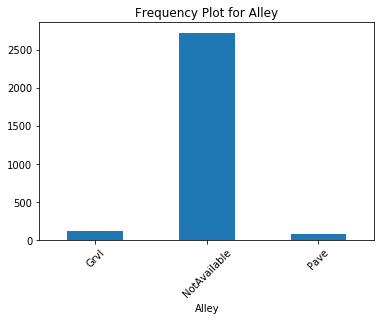

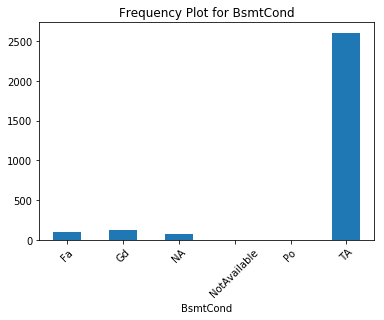

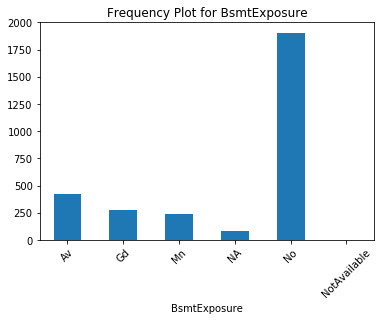

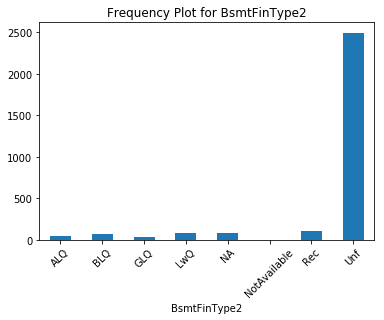

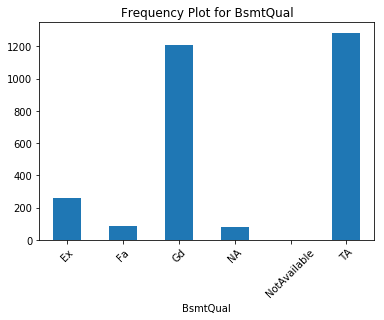

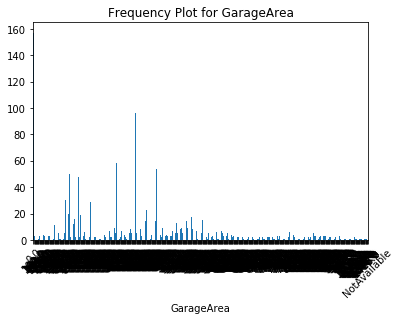

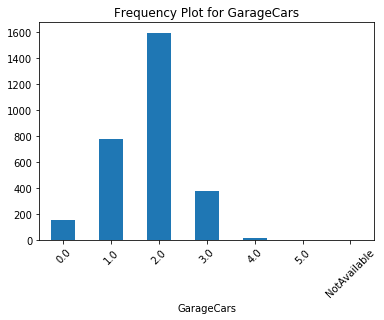

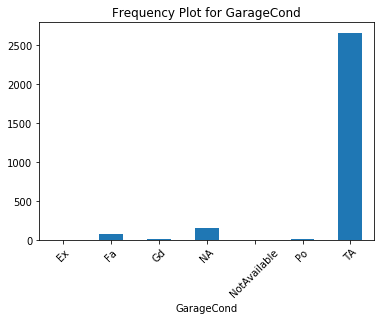

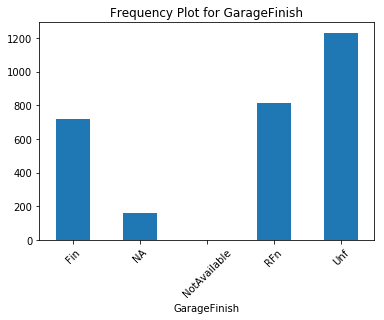

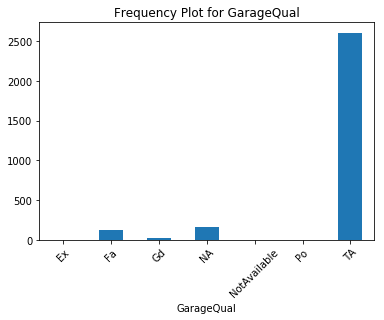

In [25]:
plotNAs(df_kitchen.copy())

In [26]:
def bsmtInterpolate(df):
    bsmt_column = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']
    print(bsmt_column)
    
    bsmt_column2 = [c for c in list(df) if 'Bsmt' in c]
    
    dd(df[df.BsmtCond.isna()][bsmt_column])
    bsmt_index = []
    bsmt_index += list(df[df.BsmtCond.isna()].index)
    
    dd(df[df.BsmtExposure.isna()][bsmt_column])
    bsmt_index += list(df[df.BsmtExposure.isna()].index)
    
    dd(df[df.BsmtFinType2.isna()][bsmt_column])
    bsmt_index += list(df[df.BsmtFinType2.isna()].index)
    
    dd(df[df.BsmtQual.isna()][bsmt_column])
    bsmt_index += list(df[df.BsmtQual.isna()].index)
    
    df1 = df.groupby(bsmt_column).agg('count').reset_index()[(bsmt_column + ['SalePrice'])]
    df1 = df1.sort_values('SalePrice',ascending=False)
    #dd(df1)
    
    def getBsmtCond(BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual):
        return df1[(df1.BsmtExposure == BsmtExposure)&
                   (df1.BsmtFinType1 == BsmtFinType1)&
                   (df1.BsmtFinType2 == BsmtFinType2)&
                   (df1.BsmtQual == BsmtQual)                   
                  ]['BsmtCond'].tolist()[0]
    
    def getBsmtExposure(BsmtCond, BsmtFinType1, BsmtFinType2, BsmtQual):
        return df1[(df1.BsmtCond == BsmtCond)&
                   (df1.BsmtFinType1 == BsmtFinType1)&
                   (df1.BsmtFinType2 == BsmtFinType2)&
                   (df1.BsmtQual == BsmtQual)                   
                  ]['BsmtExposure'].tolist()[0]
    
    def getBsmtFinType1(BsmtExposure, BsmtCond, BsmtFinType2, BsmtQual):
        return df1[(df1.BsmtExposure == BsmtExposure)&
                   (df1.BsmtCond == BsmtCond)&
                   (df1.BsmtFinType2 == BsmtFinType2)&
                   (df1.BsmtQual == BsmtQual)                   
                  ]['BsmtFinType1'].tolist()[0]
    
    def getBsmtFinType2(BsmtExposure, BsmtFinType1, BsmtCond, BsmtQual):
        return df1[(df1.BsmtExposure == BsmtExposure)&
                   (df1.BsmtFinType1 == BsmtFinType1)&
                   (df1.BsmtCond == BsmtCond)&
                   (df1.BsmtQual == BsmtQual)                   
                  ]['BsmtFinType2'].tolist()[0]
    
    def getBsmtQual(BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtCond):
        return df1[(df1.BsmtExposure == BsmtExposure)&
                   (df1.BsmtFinType1 == BsmtFinType1)&
                   (df1.BsmtFinType2 == BsmtFinType2)&
                   (df1.BsmtCond == BsmtCond)                   
                  ]['BsmtQual'].tolist()[0]
    
    #['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']
    df['BsmtCond'] = df.BsmtCond.fillna("NA")
    df['BsmtCond'] = df.apply(lambda x: getBsmtCond(x['BsmtExposure'], x['BsmtFinType1'], x['BsmtFinType2'], x['BsmtQual'])
                              if x['BsmtCond'] == "NA" else x['BsmtCond']
                             , axis = 1)
    
    df['BsmtExposure'] = df.BsmtExposure.fillna("NA")
    df['BsmtExposure'] = df.apply(lambda x: getBsmtExposure(x['BsmtCond'], x['BsmtFinType1'], x['BsmtFinType2'], x['BsmtQual'])
                              if x['BsmtExposure'] == "NA" else x['BsmtExposure']
                             , axis = 1)
    
    df['BsmtFinType1'] = df.BsmtFinType1.fillna("NA")
    df['BsmtFinType1'] = df.apply(lambda x: getBsmtFinType1(x['BsmtExposure'], x['BsmtCond'], x['BsmtFinType2'], x['BsmtQual'])
                              if x['BsmtFinType1'] == "NA" else x['BsmtFinType1']
                             , axis = 1)

    df['BsmtFinType2'] = df.BsmtFinType2.fillna("NA")
    df['BsmtFinType2'] = df.apply(lambda x: getBsmtFinType2(x['BsmtExposure'], x['BsmtFinType1'], x['BsmtCond'], x['BsmtQual'])
                              if x['BsmtFinType2'] == "NA" else x['BsmtFinType2']
                             , axis = 1)
    
    df['BsmtQual'] = df.BsmtQual.fillna("NA")
    df['BsmtQual'] = df.apply(lambda x: getBsmtQual(x['BsmtExposure'], x['BsmtFinType1'], x['BsmtFinType2'], x['BsmtCond'])
                              if x['BsmtQual'] == "NA" else x['BsmtQual']
                             , axis = 1)
    
    dd(df[df.index.isin(bsmt_index)][bsmt_column])
    
    return df
df_bsmt_final = bsmtInterpolate(df_kitchen.copy())


['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']


,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
2040,NaN,Mn,GLQ,Rec,Gd
2185,NaN,No,BLQ,Unf,TA
2524,NaN,Av,ALQ,Unf,TA


,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
948,TA,NaN,Unf,Unf,Gd
1487,TA,NaN,Unf,Unf,Gd
2348,TA,NaN,Unf,Unf,Gd


,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
332,TA,No,GLQ,NaN,Gd


,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
2217,Fa,No,Unf,Unf,NaN
2218,TA,No,Unf,Unf,NaN


,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
332,TA,No,GLQ,Unf,Gd
948,TA,No,Unf,Unf,Gd
1487,TA,No,Unf,Unf,Gd
2040,TA,Mn,GLQ,Rec,Gd
2185,TA,No,BLQ,Unf,TA
2217,Fa,No,Unf,Unf,TA
2218,TA,No,Unf,Unf,TA
2348,TA,No,Unf,Unf,Gd
2524,TA,Av,ALQ,Unf,TA


### Garage*

In [27]:
def garageWrangling(df):
    garage_columns = [c for c in df.select_dtypes(exclude=np.number) if "Garage" in c]
    print(garage_columns)
    garage_col2 = [c for c in list(df) if "Garage" in c]
    grp_by = ['GarageType','MiscFeature','OverallQual','OverallCond','GarageFinish','GarageQual','GarageCond',\
              'GarageArea','GarageCars']
    
    new_col = list(set(garage_col2 + grp_by + ['MiscFeature']))
    
    miss_index = []
    for c in garage_col2:
        df_temp = df[df[c].isna()][new_col]
        dd(c,df_temp)
        miss_index += list(df_temp.index)
    
    
    df1 = df.groupby(grp_by).agg('count').reset_index().sort_values('SalePrice',ascending=False)[grp_by + ['SalePrice']]
    dd(df1[df1.GarageType == 'Detchd'])
    
    def getGarageArea( GarageType, MiscFeature, OverallQual, OverallCond):
        return df1[
                   (df1.GarageType == GarageType) &
                   (df1.MiscFeature == MiscFeature) &
                   (df1.OverallQual == OverallQual) &
                   (df1.OverallCond == OverallCond)
                  ]['GarageArea'].tolist()[0]
    
    def getGarageCars( GarageType, MiscFeature, OverallQual, OverallCond):
        return df1[
                   (df1.GarageType == GarageType) &
                   (df1.MiscFeature == MiscFeature) &
                   (df1.OverallQual == OverallQual) &
                   (df1.OverallCond == OverallCond)
                  ]['GarageCars'].tolist()[0]
    
    def getGarageCond(GarageType, MiscFeature, OverallQual, OverallCond):
        return df1[
                   (df1.GarageType == GarageType) &
                   (df1.MiscFeature == MiscFeature) &
                   (df1.OverallQual == OverallQual) &
                   (df1.OverallCond == OverallCond)
                  ]['GarageCond'].tolist()[0]
    
    def getGarageFinish(GarageType, MiscFeature, OverallQual, OverallCond):
        return df1[
                   (df1.GarageType == GarageType) &
                   (df1.MiscFeature == MiscFeature) &
                   (df1.OverallQual == OverallQual) &
                   (df1.OverallCond == OverallCond)
                  ]['GarageFinish'].tolist()[0]
    
    def getGarageQual(GarageType, MiscFeature, OverallQual, OverallCond):
        return df1[
                   (df1.GarageType == GarageType) &
                   (df1.MiscFeature == MiscFeature) &
                   (df1.OverallQual == OverallQual) &
                   (df1.OverallCond == OverallCond)
                  ]['GarageQual'].tolist()[0]
    
    df['GarageArea'] = df['GarageArea'].fillna("NA")
    df['GarageArea'] = df.apply(lambda x: getGarageArea( x['GarageType'], x['MiscFeature'], x['OverallQual'], x['OverallCond'])
                                if x['GarageArea'] =="NA" else x['GarageArea']
                                ,axis =1)
    
    df['GarageCars'] = df['GarageCars'].fillna("NA")
    df['GarageCars'] = df.apply(lambda x: getGarageCars( x['GarageType'], x['MiscFeature'], x['OverallQual'], x['OverallCond'])
                                if x['GarageCars'] =="NA" else x['GarageCars']
                                ,axis =1)
    
    df['GarageCond'] = df['GarageCond'].fillna("NA")
    df['GarageCond'] = df.apply(lambda x: getGarageCond( x['GarageType'], x['MiscFeature'], x['OverallQual'], x['OverallCond'])
                                if x['GarageCond'] =="NA" else x['GarageCond']
                                ,axis =1)
    
    df['GarageFinish'] = df['GarageFinish'].fillna("NA")
    df['GarageFinish'] = df.apply(lambda x: getGarageFinish( x['GarageType'], x['MiscFeature'], x['OverallQual'], x['OverallCond'])
                                if x['GarageFinish'] =="NA" else x['GarageFinish']
                                ,axis =1)
    
    df['GarageQual'] = df['GarageQual'].fillna("NA")
    df['GarageQual'] = df.apply(lambda x: getGarageQual( x['GarageType'], x['MiscFeature'], x['OverallQual'], x['OverallCond'])
                                if x['GarageQual'] =="NA" else x['GarageQual']
                                ,axis =1)
    
    dd(df[df.index.isin(miss_index)][new_col])
    return df
df_garage_final = garageWrangling(df_bsmt_final.copy())


['GarageCond', 'GarageFinish', 'GarageQual', 'GarageType']


'GarageArea'

,MiscFeature,GarageArea,GarageType,OverallQual,GarageCars,OverallCond,GarageCond,GarageQual,GarageFinish
2576,NA,NaN,Detchd,5,NaN,6,NaN,NaN,NaN


'GarageCars'

,MiscFeature,GarageArea,GarageType,OverallQual,GarageCars,OverallCond,GarageCond,GarageQual,GarageFinish
2576,NA,NaN,Detchd,5,NaN,6,NaN,NaN,NaN


'GarageCond'

,MiscFeature,GarageArea,GarageType,OverallQual,GarageCars,OverallCond,GarageCond,GarageQual,GarageFinish
2126,Shed,360.0,Detchd,6,1.0,8,NaN,NaN,NaN
2576,NA,NaN,Detchd,5,NaN,6,NaN,NaN,NaN


'GarageFinish'

,MiscFeature,GarageArea,GarageType,OverallQual,GarageCars,OverallCond,GarageCond,GarageQual,GarageFinish
2126,Shed,360.0,Detchd,6,1.0,8,NaN,NaN,NaN
2576,NA,NaN,Detchd,5,NaN,6,NaN,NaN,NaN


'GarageQual'

,MiscFeature,GarageArea,GarageType,OverallQual,GarageCars,OverallCond,GarageCond,GarageQual,GarageFinish
2126,Shed,360.0,Detchd,6,1.0,8,NaN,NaN,NaN
2576,NA,NaN,Detchd,5,NaN,6,NaN,NaN,NaN


'GarageType'

,MiscFeature,GarageArea,GarageType,OverallQual,GarageCars,OverallCond,GarageCond,GarageQual,GarageFinish


,GarageType,MiscFeature,OverallQual,OverallCond,GarageFinish,GarageQual,GarageCond,GarageArea,GarageCars,SalePrice
1987,Detchd,NA,6,5,Unf,TA,TA,440.0,2.0,13
1812,Detchd,NA,5,5,Unf,TA,TA,576.0,2.0,13
1979,Detchd,NA,6,5,Unf,TA,TA,264.0,1.0,11
1865,Detchd,NA,5,6,Unf,TA,TA,576.0,2.0,9
1842,Detchd,NA,5,6,Unf,TA,TA,240.0,1.0,9
1925,Detchd,NA,5,7,Unf,TA,TA,576.0,2.0,9
2099,Detchd,NA,7,5,RFn,TA,TA,480.0,2.0,7
2051,Detchd,NA,6,7,Unf,TA,TA,240.0,1.0,6
1894,Detchd,NA,5,7,Unf,TA,TA,240.0,1.0,6
1862,Detchd,NA,5,6,Unf,TA,TA,484.0,2.0,6


,MiscFeature,GarageArea,GarageType,OverallQual,GarageCars,OverallCond,GarageCond,GarageQual,GarageFinish
2126,Shed,360.0,Detchd,6,1.0,8,TA,TA,Unf
2576,NA,576.0,Detchd,5,2.0,6,TA,TA,Unf


### Checkpoint 2

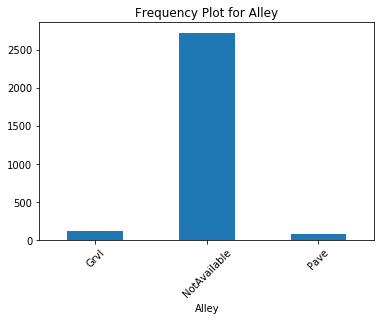

In [28]:
plotNAs(df_garage_final.copy())

In [29]:
did_we_miss_them = ['MSSubClass', 'OverallQual', 'OverallCond', 'FireplaceQu', 'MoSold']
for c in did_we_miss_them:
    dd(c, df_garage_final[c].unique())

'MSSubClass'

array(['60', '20', '70', '50', '190', '45', '90', '120', '30', '85', '80',
       '160', '75', '180', '40', '150'], dtype=object)

'OverallQual'

array(['7', '6', '8', '5', '9', '4', '10', '3', '1', '2'], dtype=object)

'OverallCond'

array(['5', '8', '6', '7', '4', '2', '3', '9', '1'], dtype=object)

'FireplaceQu'

array(['nan', 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

'MoSold'

array(['2', '5', '9', '12', '10', '8', '11', '4', '1', '7', '3', '6'],
      dtype=object)

In [30]:
def FireplaceWrangling(df_temp):
    df = pd.read_csv('train.csv')
    print("Count of missing FireplaceQu : ",df[df.FireplaceQu.isna()].shape[0])
    dd("Count of Fireplaces == 0",df[['Fireplaces', 'FireplaceQu']][df.Fireplaces == 0].shape)
    dd(df[['Fireplaces', 'FireplaceQu']][df.FireplaceQu.isna()].head())
    dd("When FireplaceQu == NA, Fireplaces:", df[['Fireplaces', 'FireplaceQu']][df.FireplaceQu.isna()]['Fireplaces'].unique())
    dd("When Fireplaces == 0, FireplaceQu:",df[['Fireplaces', 'FireplaceQu']][df.Fireplaces == 0]['FireplaceQu'].unique())
    
    #now we have NA as nan in our wrangled dataset; ideally this should not be problem but let us be consistent.
    df = df_temp.copy()
    
    df['FireplaceQu'] = df.apply(lambda x: "NA" if x['Fireplaces'] == 0 else x['FireplaceQu'], axis=1 )
    
    dd(df.FireplaceQu.unique())
    
    return df
    
df_fire = FireplaceWrangling(df_garage_final.copy())

Count of missing FireplaceQu :  690


'Count of Fireplaces == 0'

(690, 2)

,Fireplaces,FireplaceQu
0,0,NaN
5,0,NaN
10,0,NaN
12,0,NaN
15,0,NaN


'When FireplaceQu == NA, Fireplaces:'

array([0], dtype=int64)

'When Fireplaces == 0, FireplaceQu:'

array([nan], dtype=object)

array(['NA', 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

##### FireplaceQu will be mapped to NA (no fireplace) whenever Fireplaces = 0

##### TotalBsmtSF = 0 indicates there is no basement. 
* Therefore, BsmtQual = BsmtCond = BsmtExposure = BsmtFinType1 = BsmtFinType2 = "NA"; when TotalBsmtSF = 0 

* Outlier: (df.BsmtFinSF1 > 2000) & (df.SalePrice < 200000) (2 of them) are outlier because it not only brings the co relation down but also there are enough samples for outlier's overall condition and quality samples.

### Outliers

In [31]:
print("Shape of the imputed dataset : ", df_fire.shape)
df_out = df_fire[df_fire.SalePrice > 0].copy()
print("Shape of the Outlier Analysis dataset : ", df_out.shape)

Shape of the imputed dataset :  (2919, 79)
Shape of the Outlier Analysis dataset :  (1460, 79)


In [32]:
def computeCorrCols(df):
    df_corr = df.corr()
    
    df1 = df_corr.stack().reset_index().rename(columns={'level_0': "C1", "level_1": "C2", 0 : "Corr_val"})
    
    df1['Corr_val']= df1['Corr_val'].abs()
    df1 = df1[df1['Corr_val'] < 1].sort_values('Corr_val',ascending=False)
    df1 = df1.drop_duplicates('Corr_val').reset_index(drop=True)
    dd(df1)
    
    return df1
df_corr = computeCorrCols(df_out.copy())


,C1,C2,Corr_val
0,GarageCars,GarageArea,0.882475
1,TotRmsAbvGrd,GrLivArea,0.825489
2,TotalBsmtSF,1stFlrSF,0.819530
3,SalePrice,GrLivArea,0.708624
4,2ndFlrSF,GrLivArea,0.687501
5,BedroomAbvGr,TotRmsAbvGrd,0.676620
6,GarageCars,SalePrice,0.640409
7,FullBath,GrLivArea,0.630012
8,SalePrice,GarageArea,0.623431
9,TotRmsAbvGrd,2ndFlrSF,0.616423


In [33]:
def checkCorr(df_old):
    df = pd.get_dummies(df_old)
    corr_target = []
    df_corr = df.corr()
    for c in list(df_corr):
        corr_target.append((c, np.abs(df_corr.loc[c,'SalePrice'])))

    dd("Top 15 Numerical Variables with High Corr value for SalePrice :",
        [x for x in sorted(corr_target,key=lambda x: x[1], reverse=True) if '_' not in x[0]][1:15])
    
    dd("Top 15 Variables (All Types) with High Corr value for SalePrice :",
        [x for x in sorted(corr_target,key=lambda x: x[1], reverse=True)][1:15])

checkCorr(df_out.copy())

'Top 15 Numerical Variables with High Corr value for SalePrice :'

[('GrLivArea', 0.7086244776126511),
 ('GarageCars', 0.640409197258349),
 ('GarageArea', 0.6234314389183598),
 ('TotalBsmtSF', 0.6135805515591944),
 ('1stFlrSF', 0.6058521846919166),
 ('FullBath', 0.5606637627484452),
 ('TotRmsAbvGrd', 0.5337231555820238),
 ('YearBuilt', 0.5228973328794967),
 ('YearRemodAdd', 0.5071009671113867),
 ('Fireplaces', 0.4669288367515242),
 ('LotFrontage', 0.3426877808510241),
 ('WoodDeckSF', 0.32441344456813076),
 ('2ndFlrSF', 0.31933380283206614),
 ('OpenPorchSF', 0.31585622711605577)]

'Top 15 Variables (All Types) with High Corr value for SalePrice :'

[('GrLivArea', 0.7086244776126511),
 ('GarageCars', 0.640409197258349),
 ('GarageArea', 0.6234314389183598),
 ('TotalBsmtSF', 0.6135805515591944),
 ('1stFlrSF', 0.6058521846919166),
 ('ExterQual_TA', 0.589043523409763),
 ('FullBath', 0.5606637627484452),
 ('BsmtQual_Ex', 0.5531048470089422),
 ('TotRmsAbvGrd', 0.5337231555820238),
 ('YearBuilt', 0.5228973328794967),
 ('KitchenQual_TA', 0.5192978536548846),
 ('YearRemodAdd', 0.5071009671113867),
 ('KitchenQual_Ex', 0.5040936759052956),
 ('Foundation_PConc', 0.4977337525869438)]

##### There may be so many outliers but let us target the ones which are not only numerical but also impact the target variables. Let us target top 5 variables for outlier removal. i.e. GrLivArea, GarageCars, GarageArea, TotalBsmtSF & 1stFlrSF

In [34]:
def topCorrWithOthers(df):
    top_5_corr = ['GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']
    print("Co relation of the top 5 columns with others : ")
    for c in top_5_corr:
        dd(df_corr[(df_corr.C1 == c) | (df_corr.C2 == c)].head())
        
topCorrWithOthers(df_fire.copy())

Co relation of the top 5 columns with others : 


,C1,C2,Corr_val
1,TotRmsAbvGrd,GrLivArea,0.825489
3,SalePrice,GrLivArea,0.708624
4,2ndFlrSF,GrLivArea,0.687501
7,FullBath,GrLivArea,0.630012
14,1stFlrSF,GrLivArea,0.566024


,C1,C2,Corr_val
0,GarageCars,GarageArea,0.882475
6,GarageCars,SalePrice,0.640409
17,YearBuilt,GarageCars,0.537850
26,FullBath,GarageCars,0.469672
29,GarageCars,GrLivArea,0.467247


,C1,C2,Corr_val
0,GarageCars,GarageArea,0.882475
8,SalePrice,GarageArea,0.623431
23,GarageArea,1stFlrSF,0.489782
24,TotalBsmtSF,GarageArea,0.486665
25,YearBuilt,GarageArea,0.478954


,C1,C2,Corr_val
2,TotalBsmtSF,1stFlrSF,0.819530
10,TotalBsmtSF,SalePrice,0.613581
24,TotalBsmtSF,GarageArea,0.486665
32,GrLivArea,TotalBsmtSF,0.454868
36,GarageCars,TotalBsmtSF,0.434585


,C1,C2,Corr_val
2,TotalBsmtSF,1stFlrSF,0.819530
12,1stFlrSF,SalePrice,0.605852
14,1stFlrSF,GrLivArea,0.566024
23,GarageArea,1stFlrSF,0.489782
33,GarageCars,1stFlrSF,0.439317


### 1. GrLivArea

Co relation before removing the outlier :  0.7086244776126511
Co relation After removing the outlier :  0.7349681645359343


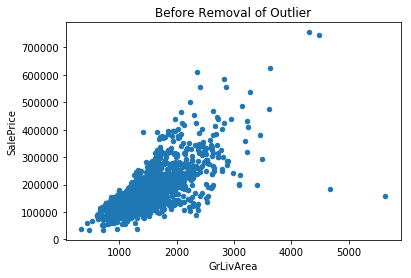

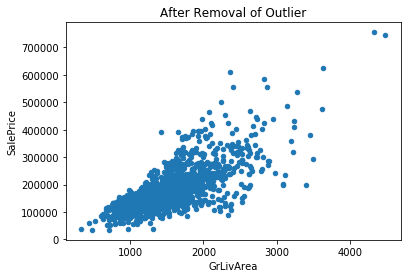

In [35]:
def grLivAreaOutlier(df):
    df.plot.scatter("GrLivArea", "SalePrice", title="Before Removal of Outlier")
    df_corr = df.corr()
    print("Co relation before removing the outlier : ",df_corr.loc['GrLivArea','SalePrice'])
    df1 = df[(df.GrLivArea < 4000) | (df.SalePrice >250000 )]
    df1.plot.scatter("GrLivArea", "SalePrice", title="After Removal of Outlier")
    
    #dd(corr(df1.GrLivArea, df1.SalePrice))
    
    df_corr = df1.corr()
    print("Co relation After removing the outlier : ",df_corr.loc['GrLivArea','SalePrice'])
    
    return df1
df_liv = grLivAreaOutlier(df_out.copy())

### 2. GarageCars

Co relation before removing the outlier :  0.6410470076412783
Outlier Count :  5
Co relation After removing the outlier :  0.6500218160448563


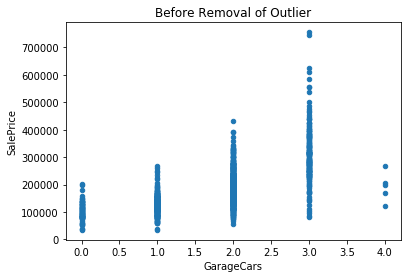

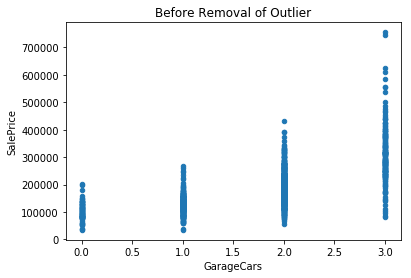

In [36]:
def garageCarsOutlier(df):
    df.plot.scatter("GarageCars", "SalePrice", title="Before Removal of Outlier")
    df_corr = df.corr()
    print("Co relation before removing the outlier : ",df_corr.loc['GarageCars','SalePrice'])
    
    df1 = df[(df.GarageCars < 4)]
    
    print("Outlier Count : ", df[(df.GarageCars == 4)].shape[0])
    df_corr = df1.corr()
    print("Co relation After removing the outlier : ",df_corr.loc['GarageCars','SalePrice'])
    df1.plot.scatter("GarageCars", "SalePrice", title="Before Removal of Outlier")
    return df1
    
df_gar_car = garageCarsOutlier(df_liv.copy())

### 3.GarageArea

Co relation before removing the outlier :  0.6342585742266152
Outlier Count :  2
Co relation After removing the outlier :  0.6425301757814186


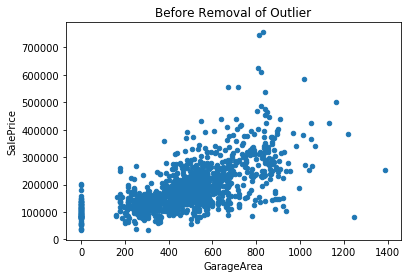

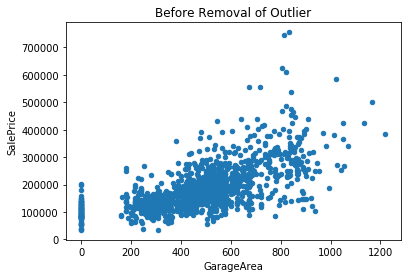

In [37]:
def garageAreaOutlier(df):
    df.plot.scatter("GarageArea", "SalePrice", title="Before Removal of Outlier")
    df_corr = df.corr()
    print("Co relation before removing the outlier : ",df_corr.loc['GarageArea','SalePrice'])
    
    df1 = df[(df.GarageArea < 1200) | (df.SalePrice > 300000)]
    
    print("Outlier Count : ", df[(df.GarageArea > 1200) & (df.SalePrice < 300000)].shape[0])
    df_corr = df1.corr()
    print("Co relation After removing the outlier : ",df_corr.loc['GarageArea','SalePrice'])
    df1.plot.scatter("GarageArea", "SalePrice", title="Before Removal of Outlier")
    
    return df1

df_gar_area = garageAreaOutlier(df_gar_car.copy())

### 4. TotalBsmtSF

Co relation before removing the outlier :  0.6511525485753985
Outlier Count :  1
Co relation After removing the outlier :  0.6529878477157007


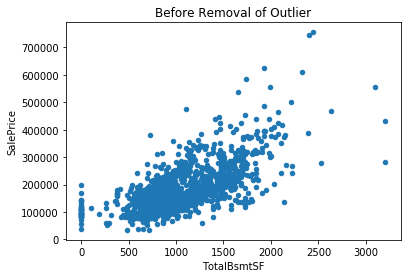

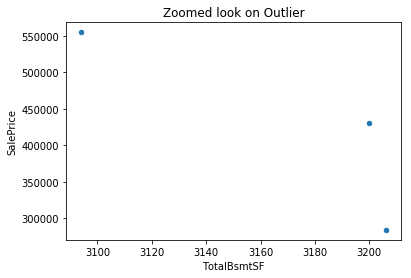

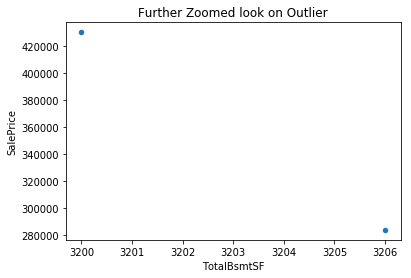

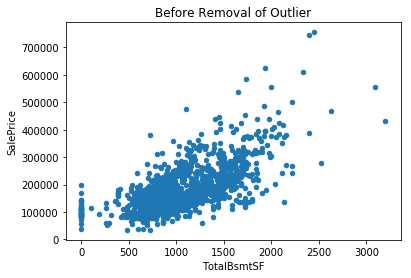

In [38]:
def totalBsmtSFOutlier(df):
    df.plot.scatter("TotalBsmtSF", "SalePrice", title="Before Removal of Outlier")
    df_corr = df.corr()
    print("Co relation before removing the outlier : ",df_corr.loc['TotalBsmtSF','SalePrice'])
    df[df.TotalBsmtSF >3000].plot.scatter("TotalBsmtSF", "SalePrice", title="Zoomed look on Outlier")
    df[df.TotalBsmtSF >3100].plot.scatter("TotalBsmtSF", "SalePrice", title="Further Zoomed look on Outlier")
    
    df1 = df[(df.TotalBsmtSF < 3000) | (df.SalePrice > 300000)]
    
    print("Outlier Count : ", df[(df.TotalBsmtSF > 3000) & (df.SalePrice < 300000)].shape[0])
    df_corr = df1.corr()
    print("Co relation After removing the outlier : ",df_corr.loc['TotalBsmtSF','SalePrice'])
    df1.plot.scatter("TotalBsmtSF", "SalePrice", title="Before Removal of Outlier")
    
    return df1

df_tot = totalBsmtSFOutlier(df_gar_area.copy())

### 5. 1stFlrSF

Co relation before removing the outlier :  0.6311304630874277
Outlier Count :  1
Co relation After removing the outlier :  0.6279538493477107


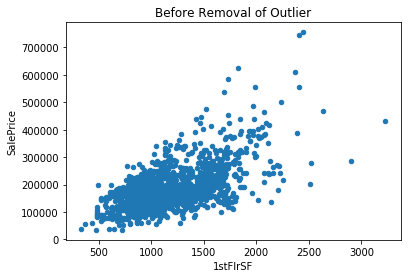

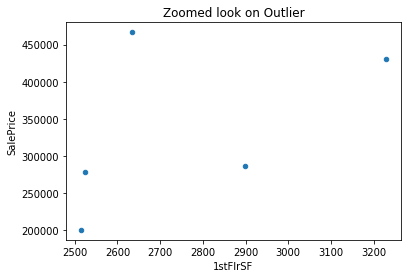

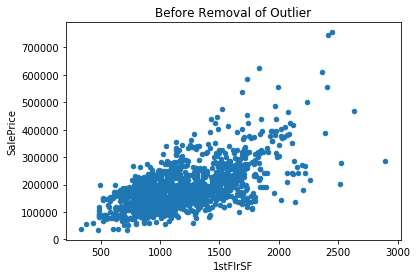

In [39]:
def firststFlrSFOutlierCheck(df):
    df.plot.scatter("1stFlrSF", "SalePrice", title="Before Removal of Outlier")
    df_corr = df.corr()
    print("Co relation before removing the outlier : ",df_corr.loc['1stFlrSF','SalePrice'])
    df[df['1stFlrSF'] >2500].plot.scatter("1stFlrSF", "SalePrice", title="Zoomed look on Outlier")
    #df[df.TotalBsmtSF >3100].plot.scatter("1stFlrSF", "SalePrice", title="Further Zoomed look on Outlier")
    
    df1 = df[(df['1stFlrSF'] < 3000) ]
    
    print("Outlier Count : ", df[(df['1stFlrSF'] > 3000)].shape[0])
    df_corr = df1.corr()
    print("Co relation After removing the outlier : ",df_corr.loc['1stFlrSF','SalePrice'])
    df1.plot.scatter("1stFlrSF", "SalePrice", title="Before Removal of Outlier")
    
    return df1
    
df_1stFlrSF = firststFlrSFOutlierCheck(df_tot.copy())

In [40]:
checkCorr(df_tot.copy())

'Top 15 Numerical Variables with High Corr value for SalePrice :'

[('GrLivArea', 0.7356192298823421),
 ('TotalBsmtSF', 0.6529878477157007),
 ('GarageCars', 0.6517497256180944),
 ('GarageArea', 0.6420005187402775),
 ('1stFlrSF', 0.6311304630874277),
 ('FullBath', 0.5623467724991926),
 ('TotRmsAbvGrd', 0.5387003379239463),
 ('YearBuilt', 0.5264875307146886),
 ('YearRemodAdd', 0.5059956680007409),
 ('Fireplaces', 0.4694161934346752),
 ('LotFrontage', 0.36238176094911934),
 ('WoodDeckSF', 0.32690947733209264),
 ('OpenPorchSF', 0.3224291048782045),
 ('2ndFlrSF', 0.3208842855427299)]

'Top 15 Variables (All Types) with High Corr value for SalePrice :'

[('GrLivArea', 0.7356192298823421),
 ('TotalBsmtSF', 0.6529878477157007),
 ('GarageCars', 0.6517497256180944),
 ('GarageArea', 0.6420005187402775),
 ('1stFlrSF', 0.6311304630874277),
 ('ExterQual_TA', 0.5909867899822667),
 ('FullBath', 0.5623467724991926),
 ('BsmtQual_Ex', 0.5593445673471333),
 ('TotRmsAbvGrd', 0.5387003379239463),
 ('YearBuilt', 0.5264875307146886),
 ('KitchenQual_TA', 0.5189528697906682),
 ('KitchenQual_Ex', 0.5108051975428096),
 ('YearRemodAdd', 0.5059956680007409),
 ('Foundation_PConc', 0.4982256406754056)]

In [41]:
checkCorr(df_1stFlrSF.copy())

'Top 15 Numerical Variables with High Corr value for SalePrice :'

[('GrLivArea', 0.7336828552385943),
 ('GarageCars', 0.6532730348561729),
 ('TotalBsmtSF', 0.6500284099619914),
 ('GarageArea', 0.6434150725800676),
 ('1stFlrSF', 0.6279538493477107),
 ('FullBath', 0.5599152407108852),
 ('TotRmsAbvGrd', 0.5367001797131222),
 ('YearBuilt', 0.5268716622548698),
 ('YearRemodAdd', 0.5068873075190516),
 ('Fireplaces', 0.46976228150867316),
 ('LotFrontage', 0.36242188607278103),
 ('WoodDeckSF', 0.32528528485465147),
 ('2ndFlrSF', 0.32377491033817873),
 ('OpenPorchSF', 0.32259998989532845)]

'Top 15 Variables (All Types) with High Corr value for SalePrice :'

[('GrLivArea', 0.7336828552385943),
 ('GarageCars', 0.6532730348561729),
 ('TotalBsmtSF', 0.6500284099619914),
 ('GarageArea', 0.6434150725800676),
 ('1stFlrSF', 0.6279538493477107),
 ('ExterQual_TA', 0.5905508591080326),
 ('BsmtQual_Ex', 0.5619119048225442),
 ('FullBath', 0.5599152407108852),
 ('TotRmsAbvGrd', 0.5367001797131222),
 ('YearBuilt', 0.5268716622548698),
 ('KitchenQual_TA', 0.5187165897040837),
 ('KitchenQual_Ex', 0.5131379539948069),
 ('YearRemodAdd', 0.5068873075190516),
 ('Foundation_PConc', 0.4977041008816112)]

#### On comparing the results from the co relation from the above 2 cells, it is clear that we [*should not*] go for the 1stFlrSF outlier removal.

#### 2.2 Wrangling
* should we try to see all the outlier or only the ones which have high co relation with target variable ?
* have both test and train data for data missing and imputation activities and NOT for outlier removal.
* is there any way we can identify the outlier in categorical values ?

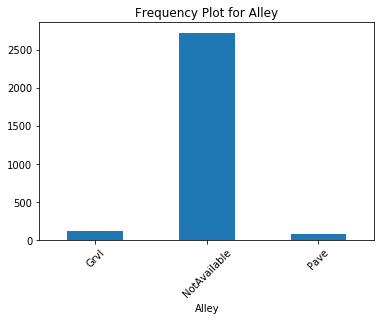

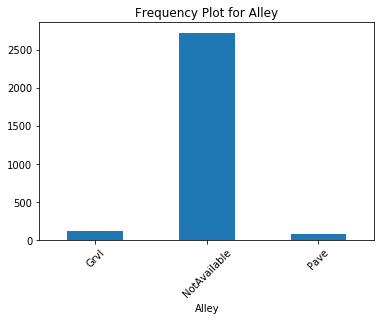

In [42]:
def interpolateAtLast(df):
   
    df[['Alley','SalePrice']].fillna('NotAvailable').\
    groupby(by='Alley').agg('count').\
    plot.bar(legend=None, title="Frequency Plot for Alley")
    plt.xticks(rotation=45)
    plt.show()
    df = df.interpolate()
    
    df[['Alley','SalePrice']].fillna('NotAvailable').\
    groupby(by='Alley').agg('count').\
    plot.bar(legend=None, title="Frequency Plot for Alley")
    plt.xticks(rotation=45)
    plt.show()
    
interpolateAtLast(df_fire.copy())

In [43]:
def interpolateCheck():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    print("Initial Shape : ", df.shape)
    
    nan_columns_before = df.columns[df.isna().any()].tolist()
    
    bsmt_columns = [c for c in list(df) if 'Bsmt' in c]
    gar_columns = [c for c in list(df) if 'Garage' in c]
    
    df_inter = df.interpolate()
    nan_columns = df_inter.columns[df_inter.isna().any()].tolist()
    
    interpolated_columns = [c for c in nan_columns_before if c not in nan_columns]
    
    display_columns = list(set(bsmt_columns + interpolated_columns + gar_columns))
    
    print("These are interpolated : ", interpolated_columns)
    
    for c in interpolated_columns:
        na_indices = df[df[c].isna()].index.tolist()
        print(c,na_indices)
        
        if 'Bsmt' in c:
            display.display(df[df.index.isin(na_indices)][bsmt_columns])
            display.display(df_inter[df_inter.index.isin(na_indices)][bsmt_columns])
        else: 
            display.display(df[df.index.isin(na_indices)][gar_columns])
            display.display(df_inter[df_inter.index.isin(na_indices)][gar_columns])
        #break
    
    '''for c in df.fillna('NotAvailable')[nan_columns]:
        df[[c,'SalePrice']].fillna('NotAvailable').\
        groupby(by=c).agg('count').\
        plot.bar(legend=None, title="Frequency Plot for "+c)
        plt.xticks(rotation=45)
        plt.show()'''
interpolateCheck()

Initial Shape :  (2919, 81)
These are interpolated :  ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'SalePrice', 'TotalBsmtSF']
BsmtFinSF1 [2120]


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,74.0,0.0,NaN,NaN,0.5,0.5,NaN,560.5,634.5


BsmtFinSF2 [2120]


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,74.0,0.0,NaN,NaN,0.5,0.5,NaN,560.5,634.5


BsmtFullBath [2120, 2188]


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2188,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,74.0,0.0,NaN,NaN,0.5,0.5,NaN,560.5,634.5
2188,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0


BsmtHalfBath [2120, 2188]


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2188,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,74.0,0.0,NaN,NaN,0.5,0.5,NaN,560.5,634.5
2188,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0


BsmtUnfSF [2120]


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,74.0,0.0,NaN,NaN,0.5,0.5,NaN,560.5,634.5


GarageArea [2576]


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
2576,NaN,NaN,NaN,NaN,NaN,Detchd,NaN


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
2576,50.0,0.5,NaN,NaN,NaN,Detchd,1936.333333


GarageCars [2576]


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
2576,NaN,NaN,NaN,NaN,NaN,Detchd,NaN


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
2576,50.0,0.5,NaN,NaN,NaN,Detchd,1936.333333


GarageYrBlt [39, 48, 78, 88, 89, 99, 108, 125, 127, 140, 148, 155, 163, 165, 198, 210, 241, 250, 287, 291, 307, 375, 386, 393, 431, 434, 441, 464, 495, 520, 528, 533, 535, 562, 582, 613, 614, 620, 635, 636, 638, 649, 705, 710, 738, 750, 784, 826, 843, 921, 942, 954, 960, 968, 970, 976, 1009, 1011, 1030, 1038, 1096, 1123, 1131, 1137, 1143, 1173, 1179, 1218, 1219, 1234, 1257, 1283, 1323, 1325, 1326, 1337, 1349, 1407, 1449, 1450, 1453, 1513, 1531, 1539, 1552, 1556, 1558, 1560, 1590, 1593, 1594, 1614, 1615, 1717, 1721, 1787, 1808, 1810, 1811, 1819, 1822, 1831, 1834, 1836, 1839, 1847, 1893, 2010, 2081, 2090, 2093, 2096, 2099, 2104, 2126, 2135, 2151, 2153, 2189, 2190, 2191, 2192, 2193, 2212, 2238, 2246, 2353, 2354, 2398, 2399, 2422, 2426, 2552, 2553, 2557, 2575, 2576, 2579, 2603, 2609, 2691, 2693, 2708, 2767, 2771, 2789, 2791, 2799, 2859, 2862, 2870, 2888, 2891, 2892, 2893, 2909, 2913, 2914, 2917]


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
39,0.0,0.0,NaN,NaN,NaN,NaN,NaN
48,0.0,0.0,NaN,NaN,NaN,NaN,NaN
78,0.0,0.0,NaN,NaN,NaN,NaN,NaN
88,0.0,0.0,NaN,NaN,NaN,NaN,NaN
89,0.0,0.0,NaN,NaN,NaN,NaN,NaN
99,0.0,0.0,NaN,NaN,NaN,NaN,NaN
108,0.0,0.0,NaN,NaN,NaN,NaN,NaN
125,0.0,0.0,NaN,NaN,NaN,NaN,NaN
127,0.0,0.0,NaN,NaN,NaN,NaN,NaN
140,0.0,0.0,NaN,NaN,NaN,NaN,NaN


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
39,0.0,0.0,NaN,NaN,NaN,NaN,1959.000000
48,0.0,0.0,NaN,NaN,NaN,NaN,1986.000000
78,0.0,0.0,NaN,NaN,NaN,NaN,1957.000000
88,0.0,0.0,NaN,NaN,NaN,NaN,1989.333333
89,0.0,0.0,NaN,NaN,NaN,NaN,1969.666667
99,0.0,0.0,NaN,NaN,NaN,NaN,1948.500000
108,0.0,0.0,NaN,NaN,NaN,NaN,1962.500000
125,0.0,0.0,NaN,NaN,NaN,NaN,1978.000000
127,0.0,0.0,NaN,NaN,NaN,NaN,1971.500000
140,0.0,0.0,NaN,NaN,NaN,NaN,2001.000000


LotFrontage [7, 12, 14, 16, 24, 31, 42, 43, 50, 64, 66, 76, 84, 95, 100, 104, 111, 113, 116, 120, 126, 131, 133, 136, 147, 149, 152, 153, 160, 166, 169, 170, 177, 180, 186, 191, 203, 207, 208, 214, 218, 221, 234, 237, 244, 249, 269, 287, 288, 293, 307, 308, 310, 319, 328, 330, 335, 342, 346, 347, 351, 356, 360, 361, 364, 366, 369, 370, 375, 384, 392, 393, 404, 405, 412, 421, 426, 447, 452, 457, 458, 459, 465, 470, 484, 490, 496, 516, 518, 529, 537, 538, 539, 541, 545, 559, 560, 564, 569, 580, 593, 610, 611, 612, 616, 623, 626, 641, 645, 660, 666, 668, 672, 679, 682, 685, 687, 690, 706, 709, 714, 720, 721, 726, 734, 745, 746, 751, 757, 770, 783, 785, 789, 791, 794, 811, 816, 817, 822, 828, 840, 845, 851, 853, 855, 856, 859, 865, 868, 879, 882, 893, 900, 904, 908, 911, 917, 925, 927, 928, 929, 939, 941, 944, 953, 961, 967, 975, 980, 983, 988, 996, 997, 1003, 1006, 1017, 1018, 1024, 1030, 1032, 1033, 1035, 1037, 1041, 1045, 1057, 1059, 1064, 1077, 1084, 1086, 1097, 1108, 1110, 1116, 1122,

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
7,484.0,2.0,TA,RFn,TA,Attchd,1973.0
12,352.0,1.0,TA,Unf,TA,Detchd,1962.0
14,352.0,1.0,TA,RFn,TA,Attchd,1960.0
16,480.0,2.0,TA,Fin,TA,Attchd,1970.0
24,270.0,1.0,TA,Unf,TA,Attchd,1968.0
31,271.0,1.0,TA,Unf,TA,Attchd,1966.0
42,504.0,2.0,Gd,RFn,TA,Attchd,1983.0
43,308.0,1.0,TA,Unf,TA,Detchd,1977.0
50,388.0,2.0,TA,Fin,TA,Attchd,1997.0
64,645.0,2.0,TA,RFn,TA,Attchd,1998.0


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
7,484.0,2.0,TA,RFn,TA,Attchd,1973.0
12,352.0,1.0,TA,Unf,TA,Detchd,1962.0
14,352.0,1.0,TA,RFn,TA,Attchd,1960.0
16,480.0,2.0,TA,Fin,TA,Attchd,1970.0
24,270.0,1.0,TA,Unf,TA,Attchd,1968.0
31,271.0,1.0,TA,Unf,TA,Attchd,1966.0
42,504.0,2.0,Gd,RFn,TA,Attchd,1983.0
43,308.0,1.0,TA,Unf,TA,Detchd,1977.0
50,388.0,2.0,TA,Fin,TA,Attchd,1997.0
64,645.0,2.0,TA,RFn,TA,Attchd,1998.0


MasVnrArea [234, 529, 650, 936, 973, 977, 1243, 1278, 1691, 1706, 1882, 1992, 2004, 2041, 2311, 2325, 2340, 2349, 2368, 2592, 2657, 2686, 2862]


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
234,440.0,2.0,TA,Fin,TA,BuiltIn,2002.0
529,484.0,2.0,TA,RFn,TA,Attchd,1975.0
650,562.0,2.0,TA,RFn,TA,Attchd,2007.0
936,555.0,2.0,TA,RFn,TA,Attchd,2003.0
973,480.0,2.0,TA,Fin,TA,Attchd,2007.0
977,569.0,2.0,TA,Fin,TA,Attchd,2007.0
1243,850.0,3.0,TA,Fin,TA,Attchd,2006.0
1278,577.0,2.0,TA,RFn,TA,Attchd,2002.0
1691,644.0,3.0,TA,Fin,TA,BuiltIn,2002.0
1706,529.0,2.0,TA,Fin,TA,Attchd,2008.0


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
234,440.0,2.0,TA,Fin,TA,BuiltIn,2002.0
529,484.0,2.0,TA,RFn,TA,Attchd,1975.0
650,562.0,2.0,TA,RFn,TA,Attchd,2007.0
936,555.0,2.0,TA,RFn,TA,Attchd,2003.0
973,480.0,2.0,TA,Fin,TA,Attchd,2007.0
977,569.0,2.0,TA,Fin,TA,Attchd,2007.0
1243,850.0,3.0,TA,Fin,TA,Attchd,2006.0
1278,577.0,2.0,TA,RFn,TA,Attchd,2002.0
1691,644.0,3.0,TA,Fin,TA,BuiltIn,2002.0
1706,529.0,2.0,TA,Fin,TA,Attchd,2008.0


SalePrice [1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624,

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
1460,730.0,1.0,TA,Unf,TA,Attchd,1961.0
1461,312.0,1.0,TA,Unf,TA,Attchd,1958.0
1462,482.0,2.0,TA,Fin,TA,Attchd,1997.0
1463,470.0,2.0,TA,Fin,TA,Attchd,1998.0
1464,506.0,2.0,TA,RFn,TA,Attchd,1992.0
1465,440.0,2.0,TA,Fin,TA,Attchd,1993.0
1466,420.0,2.0,TA,Fin,TA,Attchd,1992.0
1467,393.0,2.0,TA,Fin,TA,Attchd,1998.0
1468,506.0,2.0,TA,Unf,TA,Attchd,1990.0
1469,525.0,2.0,TA,Fin,TA,Attchd,1970.0


,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt
1460,730.0,1.0,TA,Unf,TA,Attchd,1961.0
1461,312.0,1.0,TA,Unf,TA,Attchd,1958.0
1462,482.0,2.0,TA,Fin,TA,Attchd,1997.0
1463,470.0,2.0,TA,Fin,TA,Attchd,1998.0
1464,506.0,2.0,TA,RFn,TA,Attchd,1992.0
1465,440.0,2.0,TA,Fin,TA,Attchd,1993.0
1466,420.0,2.0,TA,Fin,TA,Attchd,1992.0
1467,393.0,2.0,TA,Fin,TA,Attchd,1998.0
1468,506.0,2.0,TA,Unf,TA,Attchd,1990.0
1469,525.0,2.0,TA,Fin,TA,Attchd,1970.0


TotalBsmtSF [2120]


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
2120,NaN,NaN,74.0,0.0,NaN,NaN,0.5,0.5,NaN,560.5,634.5


##### We should not blindly depend on the pandas interpolate outcome. I guess we should use the method parameters that interpolate uses and then use it with a understanding. e.g.: ‘krogh’, ‘piecewise_polynomial’, ‘spline’, ‘pchip’ and ‘akima’ methods  in scipy [and thus in panda].

* TotalBsmtSF being null indicate no basement and should not impute values based on neighbor (i guess)
* basement full and half bathroom being .5 makes no sense.
* garage year built in decimals does not makes sence.

##### Let us check with XGBoost for the score.

In [44]:
def preProcessData(df, log=False):
    
    print("Shape of the data set before pre processing : ", df.shape )

    #get dummies
    if log:
        print("Categorical columns : ", list(df.select_dtypes(exclude=np.number)))
    df = pd.get_dummies(df, dtype=np.float64)
    
    print("\n\nShape of the data set after pre processing : ", df.shape )
    
    if log:
        print("Columns in the data set are : ",list(df))

    return df

df_prep = preProcessData(df_fire.copy())
df_prep.info()

Shape of the data set before pre processing :  (2919, 79)


Shape of the data set after pre processing :  (2919, 2745)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 2745 entries, 1stFlrSF to Utilities_NoSeWa
dtypes: float64(2745)
memory usage: 61.1 MB


Co relation before removing the outlier :  0.2991498429625179
Co relation After removing the outlier :  0.305921893682025
Co relation before removing the outlier :  0.23508603941745443
Outlier Count :  16
Co relation After removing the outlier :  0.24829477470837258
Co relation before removing the outlier :  0.242792379627288
Outlier Count :  4
Co relation After removing the outlier :  0.2473480306523351
Co relation before removing the outlier :  0.24982865042055918
Outlier Count :  1
Co relation After removing the outlier :  0.24788565355786552


[]

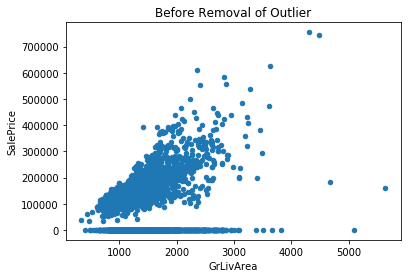

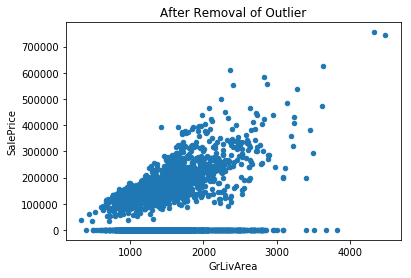

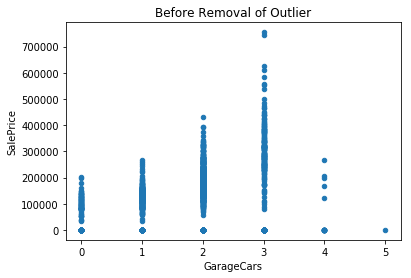

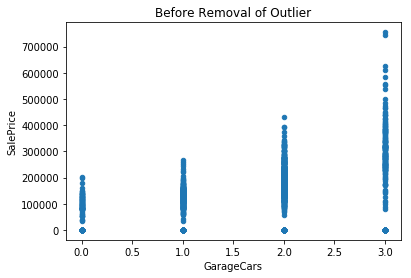

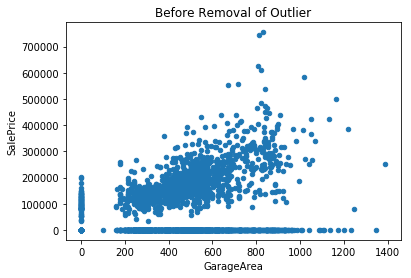

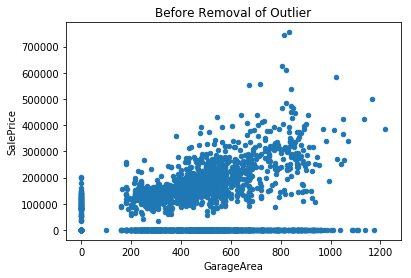

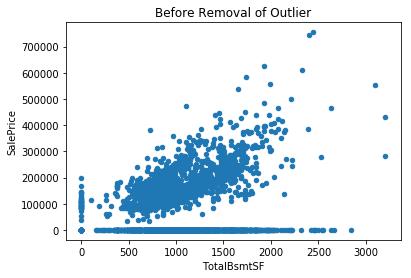

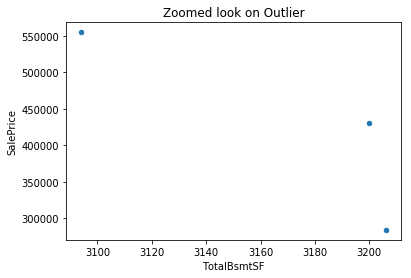

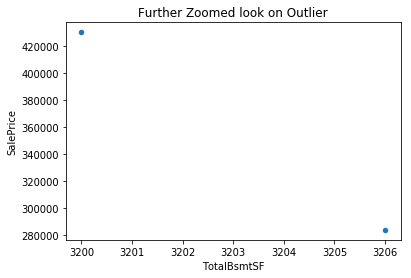

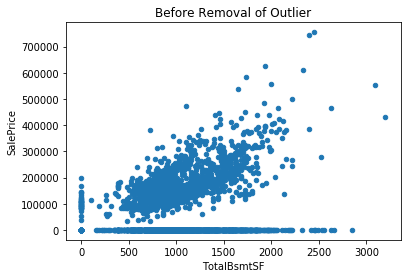

In [69]:
def getOutlierIndices(df):
    df_indices =[]
    df = grLivAreaOutlier(df)
    df = garageCarsOutlier(df)
    df = garageAreaOutlier(df)
    df = totalBsmtSFOutlier(df)
    return df_indices

getOutlierIndices(df_fire.copy())

In [ ]:
def newBoxCoxTranformation(df,target,testFile=False, log=False):
    
    #assuming that only numerical features are presented
    print("Shape of the dataset initial : ", df.shape)
    
    if not testFile:
        outlier_indices = getOutlierIndices(df)
        df =df[df.SalePrice >0]
        
        #let us remove outliers
        df = grLivAreaOutlier(df)
        df = garageCarsOutlier(df)
        df = garageAreaOutlier(df)
        df = totalBsmtSFOutlier(df)
        
        #df = preProcessData(df.copy())

        
        print("Shape of the dataset before transformation : ", df.shape)
        y = np.array(df[target].apply( lambda x: math.log(x)))
        X= df.drop(target,axis = 1)
        x_columns = list(X)
        X = preprocessing.MinMaxScaler(feature_range=(1, 2)).fit_transform(X)
        X = pd.DataFrame(X, columns=x_columns)
        
        for c in list(X):
            if len(X[c].unique()) in  [1,2]:
                if log:
                    print("Skipping Transformation for ", c, "because unique values are :",X[c].unique())
            else:
                if log:
                    print("Boxcoxing : ", c)
                X[c] = stats.boxcox(X[c])[0]

        X = X.values
        print("Shape of the dataset after transformation : ", X.shape, y.shape)
        return X,y
    else:
        df = df[df.SalePrice == 0.0]
        #df = preProcessData(df.copy())
        print("Shape of the dataset before transformation : ", df.shape)
        X=df.drop(target,axis = 1)
        x_columns = list(X)
        X = preprocessing.MinMaxScaler(feature_range=(1, 2)).fit_transform(X)
        
        X = pd.DataFrame(X, columns=x_columns)
        for c in list(X):
            if len(X[c].unique()) in  [1,2]:
                if log:
                    print("Skipping Transformation for ", c, "because unique values are :",X[c].unique())
            else:
                if log:
                    print("Boxcoxing : ", c)
                X[c] = stats.boxcox(X[c])[0]
        
        
        #X = preprocessing.power_transform( X, method='box-cox')
        X = X.values
        print("Shape of the dataset after transformation : ", X.shape)
        return X
        
    
df_prep = preProcessData(df_fire.copy())
X = newBoxCoxTranformation(df_prep.copy(),'SalePrice',True,False)  
X,y = newBoxCoxTranformation(df_prep.copy(),'SalePrice',False,False)

Shape of the data set before pre processing :  (2919, 79)


Shape of the data set after pre processing :  (2919, 2745)
Shape of the dataset initial :  (2919, 2745)
Shape of the dataset before transformation :  (1459, 2745)
Shape of the dataset after transformation :  (1459, 2744)
Shape of the dataset initial :  (2919, 2745)
Co relation before removing the outlier :  0.2991498429625179


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=random.randint(1,500))

In [ ]:
reg = XGBRegressor()
reg.fit(X_train,y_train)
reg.score(X_test,y_test)

In [ ]:
np.sqrt(mean_squared_log_error(y_test, reg.predict(X_test)))

In [ ]:
reg

In [ ]:
def checkTheTestFile(reg):
    df_test = pd.read_csv(test_File)
    df_test['SalePrice'] = 0.0
    
    #df_train =  pd.read_csv(train_File)
    #df_concat = pd.concat([df_train,df_test])

    #print(df_test[df_test.TotalBsmtSF.isna()])
    #return
    #df = giveMeWrangledData(df_concat,True)
    
    #print(df.info())
    #df = preProcessData(df)
    #print(df.info())
    X = newBoxCoxTranformation(df_fire.copy(),'SalePrice',True)
    #print(np.sqrt(mean_squared_log_error(y, reg.predict(X))))
    
    df_test['SalePrice'] = np.exp(reg.predict(X))
    
    
    return df_test, X, reg.predict(X)
df_test, X_dummy, y_dummy= checkTheTestFile(reg)